# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

from functools import partial
import re
import gc
import os

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()


import io
import requests
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from nltk import wordpunct_tokenize
from sklearn.model_selection import train_test_split
import scipy.stats


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable
import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# **Read data**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [ ]:
data.head()

,joke,rank
id,,
5tz52q,I hate how you cannot even say black paint any...,1
5tz4dd,What is the difference between a Jew in Nazi G...,0
5tz319,I recently went to America..... ...and being t...,0
5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
5tz1pc,You hear about the University book store worke...,0


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

joke    0
rank    0
dtype: int64

In [ ]:
data['rank'].value_counts()

0    60139
2    40704
4    38302
3    34199
1    18942
Name: rank, dtype: int64

# **Preprocessing**

In [ ]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

data['joke'] = data[['joke']].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["joke"][2::100000])

Tokenized:
id
5tz319    i recently went to america ..... ... and being...
3kidb9    if you think your job is meaningless . remembe...
Name: joke, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total


for line in data['joke'].values:
    token_counts.update(line.split(" "))

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(531000, 532000)
assert len(token_counts) in range(80000, 81000)
print('Correct!')

Total unique tokens : 80705
('the', 531570)
('.', 438871)
(',', 416017)
('a', 334973)
('and', 248355)
...
('uhr', 1)
('pinat', 1)
('ddr', 1)
Correct!


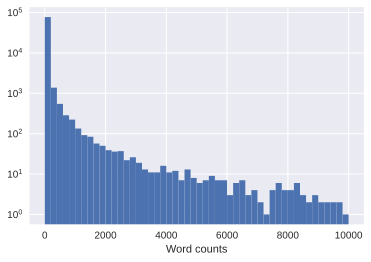

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

 Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(18000, 21000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 20434
Correct!


 Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [ ]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["joke"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["joke"][::100000]))

Lines:
i hate how you cannot even say black paint anymore . now i have to say " leroy can you please paint the fence ?"
why did the snowman leave his wife ?. because she got plowed by another man .

Matrix:
[[ 9138  8519  9003 20334  3066  6486 15656  2238 12898  1210   309 12348
   9138  8538 18466 15656    67 10507  3034 20334 13594 12898 18222  6923
    464]
 [19961  5387 18222 16734 10439  8787 19979   487  1977 16126  8008 13611
   2933  1173 11025   309     1     1     1     1     1     1     1     1
      1]]


# **Split**

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42)

data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))
print("Test size = ", len(data_test))

Train size =  123062
Validation size =  38458
Test size =  30766


In [ ]:
TARGET_COLUMN = 'rank'

In [ ]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"] = as_matrix(data["joke"].values, max_len)
    
    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'joke': tensor([[19961, 19725,  9876,     0,   588, 18222, 12157,  9659,   487,  1977],
         [19925,   257, 18151,   257,  1110,  2003, 19649,  9594,   552,  1817],
         [18965, 10500,  1326, 13581, 13676,   336, 18222, 12576, 18326,  9281]]),
 'rank': tensor([4, 1, 1])}

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

# **Utils**

In [ ]:
import os

In [ ]:
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [ ]:
def train(model, optimizer, criterion, 
          data_train, data_val, 
          batch_size=128,
          epochs=100, iter_per_validation=50,
          early_stopping=False,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy",
          device=DEVICE,  **kw):
  count = 0
  patience = 5
 
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None


  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")

      # for vec, vlen, labels in train_loader:
      for i, batch in tqdm.notebook.tqdm(
                      enumerate(iterate_minibatches(
                                          data_train, 
                                          batch_size=batch_size, 
                                          device=DEVICE)), 
                                          total=len(data_train) // batch_size
                                          ):
          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(batch)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs,  batch[TARGET_COLUMN])
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 99:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                # for i, batch in tqdm.notebook.tqdm(
                #       enumerate(iterate_minibatches(
                #                           data_val, 
                #                           batch_size=batch_size, 
                #                           device=DEVICE)), 
                #                           total=len(data_val) // batch_size
                #                           ):
                for i, batch in enumerate(iterate_minibatches(
                                        data_val, 
                                        batch_size=batch_size, 
                                        device=DEVICE)):
                    # Forward propagation
                    outputs = model(batch)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(batch[TARGET_COLUMN])
                    
                    correct += (predicted == batch[TARGET_COLUMN]).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data.detach().cpu().numpy())
                iteration_list.append(iteration)
                accuracy_list.append(accuracy.detach().cpu().numpy())
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)
                    
                 # Early stopping if the current valid_loss is greater than the last three valid losses
                if  early_stopping == True:
                    if len(accuracy_list) > 3 and all(accuracy >= acc for acc in accuracy_list[-4:]):
                        print('Stopping early')
                        break

  return iteration_list, loss_list, accuracy_list


              
              # # Early stopping if the current valid_loss is greater than the last three valid losses
              # if len(val_loss_array) > 2 and val_loss_array[-1] > val_loss_array[-2] > val_loss_array[-3]:
              #   count +=1 
              #   if count > patience:
              #     print('Early stopping, number of epoch:', epoch)
              #     break


In [ ]:
def draw_visualization(iteration_list, loss_list, accuracy_list):
    # visualization loss 
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Number of iteration")
    plt.show()

    # visualization accuracy 
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of iteration")
    plt.show()

!ls

%cd /content/drive/My Drive/NLP_humor/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

def calc_metrics(test_label, preds):
    classes_names = ['0', '1', '2', '3', '4']
    num_classes = 5

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

drive  sample_data
/content/drive/My Drive/NLP_humor


# 🚩  **1. СNN архитектура**

Добавила в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Раннюю остановку


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

# **Параллельные сверточные слои** 
(Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы)

### **CNN layers V1**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=16):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 2, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2], dim=1)

        return self.final_predictor(joke_features).squeeze()

**Training**


In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=16).to(DEVICE)
learning_rate = 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_many_conv_layers_best_checkpoint_v5",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5203094482421875  Accuracy: 34.68458938598633 %
Saving model and optimizer state at iteration 99 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 199  Loss: 1.5795584917068481  Accuracy: 33.389671325683594 %
Iteration: 299  Loss: 1.5357335805892944  Accuracy: 33.953922271728516 %
Iteration: 399  Loss: 1.5504670143127441  Accuracy: 33.543087005615234 %
Iteration: 499  Loss: 1.5293574333190918  Accuracy: 34.156742095947266 %
Iteration: 599  Loss: 1.5049954652786255  Accuracy: 33.31426239013672 %
Iteration: 699  Loss: 1.4945508241653442  Accuracy: 34.90040969848633 %
Saving model and optimizer state at iteration 699 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 799  Loss: 1.5280671119689941  Accuracy: 34.304954528808594 %
Iteration: 899  Loss: 1.4500107765197754  Accuracy: 34.494773864746094 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5422083139419556  Accuracy: 35.41525650024414 %
Saving model and optimizer state at iteration 999 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 1099  Loss: 1.5120463371276855  Accuracy: 34.219146728515625 %
Iteration: 1199  Loss: 1.5052359104156494  Accuracy: 34.5285758972168 %
Iteration: 1299  Loss: 1.4673761129379272  Accuracy: 35.50106430053711 %
Saving model and optimizer state at iteration 1299 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 1399  Loss: 1.5434519052505493  Accuracy: 35.68568420410156 %
Saving model and optimizer state at iteration 1399 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 1499  Loss: 1.5125466585159302  Accuracy: 35.867698669433594 %
Saving model and optimizer state at iteration 1499 to ./model_many_conv_layers_best_checkpoint_v5
Iteration: 1599  Loss: 1.5169085264205933  Accuracy: 33.48067855834961 %
Iteration: 1699  Loss: 1.490923285484314  Accuracy: 34.050132751464844 %
Iteration: 1799  Loss: 1.

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4792810678482056  Accuracy: 35.01482009887695 %
Iteration: 2099  Loss: 1.4529138803482056  Accuracy: 34.879608154296875 %
Iteration: 2199  Loss: 1.4783631563186646  Accuracy: 32.71360778808594 %
Iteration: 2299  Loss: 1.5471900701522827  Accuracy: 34.05533218383789 %
Iteration: 2399  Loss: 1.4624933004379272  Accuracy: 33.82651138305664 %
Iteration: 2499  Loss: 1.5071567296981812  Accuracy: 34.68458938598633 %
Iteration: 2599  Loss: 1.5312312841415405  Accuracy: 33.97212600708008 %
Iteration: 2699  Loss: 1.5044474601745605  Accuracy: 34.76519775390625 %
Iteration: 2799  Loss: 1.4683271646499634  Accuracy: 34.80160140991211 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5296218395233154  Accuracy: 34.33355712890625 %
Iteration: 2999  Loss: 1.4292197227478027  Accuracy: 33.12964630126953 %
Iteration: 3099  Loss: 1.4070675373077393  Accuracy: 33.953922271728516 %
Iteration: 3199  Loss: 1.4479056596755981  Accuracy: 33.4234733581543 %
Iteration: 3299  Loss: 1.4920921325683594  Accuracy: 33.4130744934082 %
Iteration: 3399  Loss: 1.4770870208740234  Accuracy: 34.050132751464844 %
Iteration: 3499  Loss: 1.5513253211975098  Accuracy: 33.415672302246094 %
Iteration: 3599  Loss: 1.4499443769454956  Accuracy: 33.787506103515625 %
Iteration: 3699  Loss: 1.4479106664657593  Accuracy: 34.460968017578125 %
Iteration: 3799  Loss: 1.5413877964019775  Accuracy: 34.26074981689453 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=16).to(DEVICE)
learning_rate = 0.09
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_many_conv_layers_best_checkpoint_v4",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5898160934448242  Accuracy: 33.81871032714844 %
Saving model and optimizer state at iteration 99 to ./model_many_conv_layers_best_checkpoint_v4
Iteration: 199  Loss: 1.5658657550811768  Accuracy: 33.97992706298828 %
Saving model and optimizer state at iteration 199 to ./model_many_conv_layers_best_checkpoint_v4
Iteration: 299  Loss: 1.5784111022949219  Accuracy: 33.23625564575195 %
Iteration: 399  Loss: 1.5321887731552124  Accuracy: 33.95912170410156 %
Iteration: 499  Loss: 1.5195263624191284  Accuracy: 31.865930557250977 %
Iteration: 599  Loss: 1.481669306755066  Accuracy: 34.87700653076172 %
Saving model and optimizer state at iteration 599 to ./model_many_conv_layers_best_checkpoint_v4
Iteration: 699  Loss: 1.5480481386184692  Accuracy: 33.60029220581055 %
Iteration: 799  Loss: 1.475813865661621  Accuracy: 33.38187026977539 %
Iteration: 899  Loss: 1.5405246019363403  Accuracy: 34.02412796020508 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5215150117874146  Accuracy: 33.80310821533203 %
Iteration: 1099  Loss: 1.4667409658432007  Accuracy: 33.70949935913086 %
Iteration: 1199  Loss: 1.5094895362854004  Accuracy: 34.69239044189453 %
Iteration: 1299  Loss: 1.493606448173523  Accuracy: 34.86400604248047 %
Iteration: 1399  Loss: 1.4993432760238647  Accuracy: 34.84580612182617 %
Iteration: 1499  Loss: 1.5285335779190063  Accuracy: 35.41525650024414 %
Saving model and optimizer state at iteration 1499 to ./model_many_conv_layers_best_checkpoint_v4
Iteration: 1599  Loss: 1.5226025581359863  Accuracy: 35.49846649169922 %
Saving model and optimizer state at iteration 1599 to ./model_many_conv_layers_best_checkpoint_v4
Iteration: 1699  Loss: 1.5181560516357422  Accuracy: 35.40485763549805 %
Iteration: 1799  Loss: 1.471868634223938  Accuracy: 32.489990234375 %
Iteration: 1899  Loss: 1.4943909645080566  Accuracy: 36.05491638183594 %
Saving model and optimizer state at iteration 1899 to ./model_many_conv_layers_

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4999500513076782  Accuracy: 33.74590301513672 %
Iteration: 2099  Loss: 1.4830899238586426  Accuracy: 35.6492805480957 %
Iteration: 2199  Loss: 1.5058752298355103  Accuracy: 33.84991455078125 %
Iteration: 2299  Loss: 1.442570686340332  Accuracy: 33.57428741455078 %
Iteration: 2399  Loss: 1.4721131324768066  Accuracy: 34.25815200805664 %
Iteration: 2499  Loss: 1.5164357423782349  Accuracy: 33.23885726928711 %
Iteration: 2599  Loss: 1.494901418685913  Accuracy: 33.76410675048828 %
Iteration: 2699  Loss: 1.416851282119751  Accuracy: 35.436058044433594 %
Iteration: 2799  Loss: 1.4841142892837524  Accuracy: 33.31166458129883 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.47379732131958  Accuracy: 35.56867218017578 %
Iteration: 2999  Loss: 1.5230381488800049  Accuracy: 33.244056701660156 %
Iteration: 3099  Loss: 1.477709412574768  Accuracy: 32.87482452392578 %
Iteration: 3199  Loss: 1.5332679748535156  Accuracy: 33.966922760009766 %
Iteration: 3299  Loss: 1.4775159358978271  Accuracy: 34.216548919677734 %
Iteration: 3399  Loss: 1.4903703927993774  Accuracy: 33.51708221435547 %
Iteration: 3499  Loss: 1.4990676641464233  Accuracy: 33.865516662597656 %
Iteration: 3599  Loss: 1.4546306133270264  Accuracy: 34.01892852783203 %
Iteration: 3699  Loss: 1.4653979539871216  Accuracy: 34.195743560791016 %
Iteration: 3799  Loss: 1.519116997718811  Accuracy: 32.9658317565918 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.475335955619812  Accuracy: 33.329864501953125 %
Iteration: 3999  Loss: 1.474351406097412  Accuracy: 34.193145751953125 %
Iteration: 4099  Loss: 1.4841920137405396  Accuracy: 32.705806732177734 %
Iteration: 4199  Loss: 1.4844545125961304  Accuracy: 33.34546661376953 %
Iteration: 4299  Loss: 1.526780605316162  Accuracy: 33.699100494384766 %
Iteration: 4399  Loss: 1.4814106225967407  Accuracy: 33.605491638183594 %
Iteration: 4499  Loss: 1.50051748752594  Accuracy: 34.590980529785156 %
Iteration: 4599  Loss: 1.4203869104385376  Accuracy: 34.06833267211914 %
Iteration: 4699  Loss: 1.5073422193527222  Accuracy: 33.990325927734375 %
Iteration: 4799  Loss: 1.4418877363204956  Accuracy: 33.506683349609375 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4799420833587646  Accuracy: 33.51188278198242 %
Iteration: 4999  Loss: 1.4615252017974854  Accuracy: 32.47958755493164 %
Iteration: 5099  Loss: 1.378780722618103  Accuracy: 34.74179458618164 %
Iteration: 5199  Loss: 1.3730005025863647  Accuracy: 34.2945556640625 %
Iteration: 5299  Loss: 1.4977936744689941  Accuracy: 33.77710723876953 %
Iteration: 5399  Loss: 1.476527214050293  Accuracy: 34.676788330078125 %
Iteration: 5499  Loss: 1.4170539379119873  Accuracy: 33.79530715942383 %
Iteration: 5599  Loss: 1.5535613298416138  Accuracy: 33.68349838256836 %
Iteration: 5699  Loss: 1.4324262142181396  Accuracy: 33.22065734863281 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4268581867218018  Accuracy: 33.459877014160156 %
Iteration: 5899  Loss: 1.4553558826446533  Accuracy: 33.28306198120117 %
Iteration: 5999  Loss: 1.5080342292785645  Accuracy: 33.74070358276367 %
Iteration: 6099  Loss: 1.4677170515060425  Accuracy: 33.33766555786133 %
Iteration: 6199  Loss: 1.4842408895492554  Accuracy: 33.49108123779297 %
Iteration: 6299  Loss: 1.371473789215088  Accuracy: 32.123355865478516 %
Iteration: 6399  Loss: 1.4519586563110352  Accuracy: 33.66789627075195 %
Iteration: 6499  Loss: 1.4372568130493164  Accuracy: 34.216548919677734 %
Iteration: 6599  Loss: 1.499513864517212  Accuracy: 34.000728607177734 %
Iteration: 6699  Loss: 1.4841371774673462  Accuracy: 34.104736328125 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4448927640914917  Accuracy: 34.039730072021484 %
Iteration: 6899  Loss: 1.5083783864974976  Accuracy: 33.60289001464844 %
Iteration: 6999  Loss: 1.4463950395584106  Accuracy: 33.87591552734375 %
Iteration: 7099  Loss: 1.4876210689544678  Accuracy: 33.40007400512695 %
Iteration: 7199  Loss: 1.4565744400024414  Accuracy: 32.99443435668945 %
Iteration: 7299  Loss: 1.474583625793457  Accuracy: 34.674190521240234 %
Iteration: 7399  Loss: 1.4724137783050537  Accuracy: 32.9918327331543 %
Iteration: 7499  Loss: 1.4414269924163818  Accuracy: 33.67829895019531 %
Iteration: 7599  Loss: 1.4380335807800293  Accuracy: 33.496280670166016 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4812288284301758  Accuracy: 33.914920806884766 %
Iteration: 7799  Loss: 1.4544278383255005  Accuracy: 33.52748489379883 %
Iteration: 7899  Loss: 1.4139801263809204  Accuracy: 33.85251235961914 %
Iteration: 7999  Loss: 1.4445364475250244  Accuracy: 33.88371658325195 %
Iteration: 8099  Loss: 1.4754728078842163  Accuracy: 33.595088958740234 %
Iteration: 8199  Loss: 1.4925782680511475  Accuracy: 33.04644012451172 %
Iteration: 8299  Loss: 1.4254019260406494  Accuracy: 32.93722915649414 %
Iteration: 8399  Loss: 1.4639925956726074  Accuracy: 34.66638946533203 %
Iteration: 8499  Loss: 1.5125235319137573  Accuracy: 33.89411926269531 %
Iteration: 8599  Loss: 1.421055555343628  Accuracy: 33.57428741455078 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.4457405805587769  Accuracy: 33.86811447143555 %
Iteration: 8799  Loss: 1.373392105102539  Accuracy: 33.098445892333984 %
Iteration: 8899  Loss: 1.5170598030090332  Accuracy: 32.80721664428711 %
Iteration: 8999  Loss: 1.399010181427002  Accuracy: 34.016326904296875 %
Iteration: 9099  Loss: 1.4146143198013306  Accuracy: 34.229549407958984 %
Iteration: 9199  Loss: 1.4727650880813599  Accuracy: 33.92272186279297 %
Iteration: 9299  Loss: 1.479243516921997  Accuracy: 34.0709342956543 %
Iteration: 9399  Loss: 1.4510900974273682  Accuracy: 34.037132263183594 %
Iteration: 9499  Loss: 1.4820795059204102  Accuracy: 33.8369140625 %
Iteration: 9599  Loss: 1.4003227949142456  Accuracy: 33.24665832519531 %


In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=32).to(DEVICE)
learning_rate = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_many_conv_layers_best_checkpoint_v3",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5119622945785522  Accuracy: 31.798324584960938 %
Saving model and optimizer state at iteration 99 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 199  Loss: 1.5310988426208496  Accuracy: 34.83540344238281 %
Saving model and optimizer state at iteration 199 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 299  Loss: 1.5288766622543335  Accuracy: 34.856204986572266 %
Saving model and optimizer state at iteration 299 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 399  Loss: 1.545865535736084  Accuracy: 34.564979553222656 %
Iteration: 499  Loss: 1.5427210330963135  Accuracy: 35.048622131347656 %
Saving model and optimizer state at iteration 499 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 599  Loss: 1.5271849632263184  Accuracy: 35.3918571472168 %
Saving model and optimizer state at iteration 599 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 699  Loss: 1.5325933694839478  Accuracy: 34.216548919677734 %
Iteration:

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4590193033218384  Accuracy: 35.61807632446289 %
Saving model and optimizer state at iteration 999 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 1099  Loss: 1.4884803295135498  Accuracy: 35.347652435302734 %
Iteration: 1199  Loss: 1.5521060228347778  Accuracy: 35.118831634521484 %
Iteration: 1299  Loss: 1.5419946908950806  Accuracy: 34.52337646484375 %
Iteration: 1399  Loss: 1.4214320182800293  Accuracy: 34.74699783325195 %
Iteration: 1499  Loss: 1.5444788932800293  Accuracy: 32.75521469116211 %
Iteration: 1599  Loss: 1.5167028903961182  Accuracy: 35.60507583618164 %
Iteration: 1699  Loss: 1.492646336555481  Accuracy: 35.89630126953125 %
Saving model and optimizer state at iteration 1699 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 1799  Loss: 1.5096746683120728  Accuracy: 34.13594055175781 %
Iteration: 1899  Loss: 1.5287675857543945  Accuracy: 35.30864715576172 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4507125616073608  Accuracy: 35.324249267578125 %
Iteration: 2099  Loss: 1.4135921001434326  Accuracy: 32.669403076171875 %
Iteration: 2199  Loss: 1.5327649116516113  Accuracy: 34.20874786376953 %
Iteration: 2299  Loss: 1.5188461542129517  Accuracy: 34.66638946533203 %
Iteration: 2399  Loss: 1.5020368099212646  Accuracy: 34.481773376464844 %
Iteration: 2499  Loss: 1.501896858215332  Accuracy: 33.74330520629883 %
Iteration: 2599  Loss: 1.4696177244186401  Accuracy: 34.242549896240234 %
Iteration: 2699  Loss: 1.4955531358718872  Accuracy: 35.90410232543945 %
Saving model and optimizer state at iteration 2699 to ./model_many_conv_layers_best_checkpoint_v3
Iteration: 2799  Loss: 1.4806559085845947  Accuracy: 34.77299880981445 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5059181451797485  Accuracy: 34.19054412841797 %
Iteration: 2999  Loss: 1.49573814868927  Accuracy: 34.38036346435547 %
Iteration: 3099  Loss: 1.445520281791687  Accuracy: 33.865516662597656 %
Iteration: 3199  Loss: 1.4684561491012573  Accuracy: 32.73440933227539 %
Iteration: 3299  Loss: 1.517764687538147  Accuracy: 34.47917175292969 %
Iteration: 3399  Loss: 1.388458013534546  Accuracy: 34.46617126464844 %
Iteration: 3499  Loss: 1.4464077949523926  Accuracy: 33.592491149902344 %
Iteration: 3599  Loss: 1.487440586090088  Accuracy: 33.951324462890625 %
Iteration: 3699  Loss: 1.508573293685913  Accuracy: 33.40007400512695 %
Iteration: 3799  Loss: 1.5206438302993774  Accuracy: 33.73290252685547 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.447030782699585  Accuracy: 34.18794631958008 %
Iteration: 3999  Loss: 1.4116283655166626  Accuracy: 32.7578125 %
Iteration: 4099  Loss: 1.4495341777801514  Accuracy: 32.3183708190918 %
Iteration: 4199  Loss: 1.408345103263855  Accuracy: 33.205055236816406 %
Iteration: 4299  Loss: 1.4484065771102905  Accuracy: 32.89042663574219 %
Iteration: 4399  Loss: 1.5292437076568604  Accuracy: 32.971031188964844 %
Iteration: 4499  Loss: 1.5115668773651123  Accuracy: 34.88220977783203 %
Iteration: 4599  Loss: 1.4514269828796387  Accuracy: 33.50148010253906 %
Iteration: 4699  Loss: 1.4764074087142944  Accuracy: 32.89302444458008 %
Iteration: 4799  Loss: 1.4531258344650269  Accuracy: 33.15824890136719 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4491232633590698  Accuracy: 33.701698303222656 %
Iteration: 4999  Loss: 1.5047862529754639  Accuracy: 33.57168960571289 %
Iteration: 5099  Loss: 1.4532698392868042  Accuracy: 34.27115249633789 %
Iteration: 5199  Loss: 1.4446003437042236  Accuracy: 33.173851013183594 %
Iteration: 5299  Loss: 1.4645086526870728  Accuracy: 33.8707160949707 %
Iteration: 5399  Loss: 1.5186184644699097  Accuracy: 33.688697814941406 %
Iteration: 5499  Loss: 1.4173965454101562  Accuracy: 34.0709342956543 %
Iteration: 5599  Loss: 1.4111981391906738  Accuracy: 32.73440933227539 %
Iteration: 5699  Loss: 1.4889631271362305  Accuracy: 33.19465255737305 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4105870723724365  Accuracy: 33.11924743652344 %
Iteration: 5899  Loss: 1.465705156326294  Accuracy: 32.83061981201172 %
Iteration: 5999  Loss: 1.4687097072601318  Accuracy: 33.340267181396484 %
Iteration: 6099  Loss: 1.4099889993667603  Accuracy: 33.21285629272461 %
Iteration: 6199  Loss: 1.49886953830719  Accuracy: 33.662696838378906 %
Iteration: 6299  Loss: 1.4417040348052979  Accuracy: 33.42867660522461 %
Iteration: 6399  Loss: 1.4284297227859497  Accuracy: 33.6470947265625 %
Iteration: 6499  Loss: 1.491527795791626  Accuracy: 33.366268157958984 %
Iteration: 6599  Loss: 1.4720208644866943  Accuracy: 33.44947814941406 %
Iteration: 6699  Loss: 1.4711965322494507  Accuracy: 33.53528594970703 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.3816579580307007  Accuracy: 33.4234733581543 %
Iteration: 6899  Loss: 1.4901440143585205  Accuracy: 33.847312927246094 %
Iteration: 6999  Loss: 1.4630639553070068  Accuracy: 33.189453125 %
Iteration: 7099  Loss: 1.4627714157104492  Accuracy: 33.54048538208008 %
Iteration: 7199  Loss: 1.4320368766784668  Accuracy: 33.44167709350586 %
Iteration: 7299  Loss: 1.4720792770385742  Accuracy: 33.1972541809082 %
Iteration: 7399  Loss: 1.4616525173187256  Accuracy: 33.08544158935547 %
Iteration: 7499  Loss: 1.492498517036438  Accuracy: 34.130741119384766 %
Iteration: 7599  Loss: 1.4449379444122314  Accuracy: 34.408966064453125 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.4150936603546143  Accuracy: 33.649696350097656 %
Iteration: 7799  Loss: 1.403970718383789  Accuracy: 32.822818756103516 %
Iteration: 7899  Loss: 1.4913907051086426  Accuracy: 33.75890350341797 %
Iteration: 7999  Loss: 1.3633828163146973  Accuracy: 34.04233169555664 %
Iteration: 8099  Loss: 1.369784951210022  Accuracy: 33.54048538208008 %
Iteration: 8199  Loss: 1.5152146816253662  Accuracy: 32.989234924316406 %
Iteration: 8299  Loss: 1.5229668617248535  Accuracy: 33.45467758178711 %
Iteration: 8399  Loss: 1.467587947845459  Accuracy: 33.124446868896484 %
Iteration: 8499  Loss: 1.453762412071228  Accuracy: 33.51188278198242 %
Iteration: 8599  Loss: 1.4523324966430664  Accuracy: 33.09064483642578 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.3913229703903198  Accuracy: 33.60289001464844 %
Iteration: 8799  Loss: 1.429864764213562  Accuracy: 33.904518127441406 %
Iteration: 8899  Loss: 1.4397977590560913  Accuracy: 33.951324462890625 %
Iteration: 8999  Loss: 1.3775629997253418  Accuracy: 33.56388854980469 %
Iteration: 9099  Loss: 1.4677757024765015  Accuracy: 33.38706970214844 %
Iteration: 9199  Loss: 1.4739525318145752  Accuracy: 32.71100997924805 %
Iteration: 9299  Loss: 1.4584712982177734  Accuracy: 33.83951187133789 %
Iteration: 9399  Loss: 1.4005101919174194  Accuracy: 33.340267181396484 %
Iteration: 9499  Loss: 1.412480115890503  Accuracy: 33.17645263671875 %
Iteration: 9599  Loss: 1.374263048171997  Accuracy: 33.244056701660156 %


In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=64).to(DEVICE)
learning_rate = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5444387197494507  Accuracy: 34.48697280883789 %
Saving model and optimizer state at iteration 99 to ./model_many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5478618144989014  Accuracy: 34.06573486328125 %
Iteration: 299  Loss: 1.5207734107971191  Accuracy: 32.32097244262695 %
Iteration: 399  Loss: 1.5233705043792725  Accuracy: 34.64818572998047 %
Saving model and optimizer state at iteration 399 to ./model_many_conv_layers_best_checkpoint_v2
Iteration: 499  Loss: 1.4908342361450195  Accuracy: 35.454261779785156 %
Saving model and optimizer state at iteration 499 to ./model_many_conv_layers_best_checkpoint_v2
Iteration: 599  Loss: 1.5597597360610962  Accuracy: 34.30755615234375 %
Iteration: 699  Loss: 1.5383944511413574  Accuracy: 32.66420364379883 %
Iteration: 799  Loss: 1.5515618324279785  Accuracy: 32.68240737915039 %
Iteration: 899  Loss: 1.5212515592575073  Accuracy: 32.93722915649414 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5226335525512695  Accuracy: 34.5441780090332 %
Iteration: 1099  Loss: 1.5378503799438477  Accuracy: 33.61069107055664 %
Iteration: 1199  Loss: 1.5541990995407104  Accuracy: 35.121429443359375 %
Iteration: 1299  Loss: 1.523284912109375  Accuracy: 33.38187026977539 %
Iteration: 1399  Loss: 1.5296090841293335  Accuracy: 34.819801330566406 %
Iteration: 1499  Loss: 1.4868613481521606  Accuracy: 34.82240295410156 %
Iteration: 1599  Loss: 1.499920129776001  Accuracy: 34.063133239746094 %
Iteration: 1699  Loss: 1.4779937267303467  Accuracy: 34.64558792114258 %
Iteration: 1799  Loss: 1.5278195142745972  Accuracy: 34.637786865234375 %
Iteration: 1899  Loss: 1.452056884765625  Accuracy: 34.25294876098633 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5232222080230713  Accuracy: 34.84840393066406 %
Iteration: 2099  Loss: 1.531862497329712  Accuracy: 34.61178207397461 %
Iteration: 2199  Loss: 1.373598575592041  Accuracy: 34.18794631958008 %
Iteration: 2299  Loss: 1.4278439283370972  Accuracy: 33.940921783447266 %
Iteration: 2399  Loss: 1.5275704860687256  Accuracy: 33.58469009399414 %
Iteration: 2499  Loss: 1.524275779724121  Accuracy: 33.8291130065918 %
Iteration: 2599  Loss: 1.4875825643539429  Accuracy: 35.19683837890625 %
Iteration: 2699  Loss: 1.5337380170822144  Accuracy: 35.0018196105957 %
Iteration: 2799  Loss: 1.5006159543991089  Accuracy: 34.7183952331543 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4759938716888428  Accuracy: 34.44276809692383 %
Iteration: 2999  Loss: 1.476807713508606  Accuracy: 34.5623779296875 %
Iteration: 3099  Loss: 1.5163373947143555  Accuracy: 34.45317077636719 %
Iteration: 3199  Loss: 1.4309580326080322  Accuracy: 34.15934371948242 %
Iteration: 3299  Loss: 1.4511587619781494  Accuracy: 34.20094680786133 %
Iteration: 3399  Loss: 1.442756175994873  Accuracy: 34.45056915283203 %
Iteration: 3499  Loss: 1.5324782133102417  Accuracy: 34.7781982421875 %
Iteration: 3599  Loss: 1.4915987253189087  Accuracy: 35.55046844482422 %
Saving model and optimizer state at iteration 3599 to ./model_many_conv_layers_best_checkpoint_v2
Iteration: 3699  Loss: 1.522602915763855  Accuracy: 34.255550384521484 %
Iteration: 3799  Loss: 1.5175305604934692  Accuracy: 33.61589050292969 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4391273260116577  Accuracy: 34.48697280883789 %
Iteration: 3999  Loss: 1.4309982061386108  Accuracy: 33.73290252685547 %
Iteration: 4099  Loss: 1.496782660484314  Accuracy: 35.50626754760742 %
Iteration: 4199  Loss: 1.4355055093765259  Accuracy: 34.87440872192383 %
Iteration: 4299  Loss: 1.501538634300232  Accuracy: 34.70799255371094 %
Iteration: 4399  Loss: 1.4593753814697266  Accuracy: 34.996620178222656 %
Iteration: 4499  Loss: 1.4073371887207031  Accuracy: 33.64189529418945 %
Iteration: 4599  Loss: 1.469050407409668  Accuracy: 35.300846099853516 %
Iteration: 4699  Loss: 1.5311803817749023  Accuracy: 33.446876525878906 %
Iteration: 4799  Loss: 1.481507658958435  Accuracy: 33.94612121582031 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4349344968795776  Accuracy: 34.63518524169922 %
Iteration: 4999  Loss: 1.4003180265426636  Accuracy: 35.540069580078125 %
Iteration: 5099  Loss: 1.4008251428604126  Accuracy: 34.395965576171875 %
Iteration: 5199  Loss: 1.3723549842834473  Accuracy: 34.63258361816406 %
Iteration: 5299  Loss: 1.3891149759292603  Accuracy: 33.79530715942383 %
Iteration: 5399  Loss: 1.4183145761489868  Accuracy: 34.242549896240234 %
Iteration: 5499  Loss: 1.4233516454696655  Accuracy: 34.42716598510742 %
Iteration: 5599  Loss: 1.4286320209503174  Accuracy: 33.582088470458984 %
Iteration: 5699  Loss: 1.4571623802185059  Accuracy: 34.14894104003906 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.4594793319702148  Accuracy: 34.016326904296875 %
Iteration: 5899  Loss: 1.3411400318145752  Accuracy: 34.45576858520508 %
Iteration: 5999  Loss: 1.4983162879943848  Accuracy: 35.47506332397461 %
Iteration: 6099  Loss: 1.43794584274292  Accuracy: 33.953922271728516 %
Iteration: 6199  Loss: 1.5264897346496582  Accuracy: 33.914920806884766 %
Iteration: 6299  Loss: 1.4648749828338623  Accuracy: 34.02933120727539 %
Iteration: 6399  Loss: 1.3943257331848145  Accuracy: 33.66789627075195 %
Iteration: 6499  Loss: 1.4179011583328247  Accuracy: 34.458370208740234 %
Iteration: 6599  Loss: 1.378055214881897  Accuracy: 33.4130744934082 %
Iteration: 6699  Loss: 1.3979218006134033  Accuracy: 34.0449333190918 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.4099198579788208  Accuracy: 34.120338439941406 %
Iteration: 6899  Loss: 1.4003814458847046  Accuracy: 33.592491149902344 %
Iteration: 6999  Loss: 1.3800896406173706  Accuracy: 33.69389724731445 %
Iteration: 7099  Loss: 1.3637454509735107  Accuracy: 34.61958312988281 %
Iteration: 7199  Loss: 1.452078104019165  Accuracy: 34.93681335449219 %
Iteration: 7299  Loss: 1.4143160581588745  Accuracy: 33.865516662597656 %
Iteration: 7399  Loss: 1.41996431350708  Accuracy: 35.503665924072266 %
Iteration: 7499  Loss: 1.4091343879699707  Accuracy: 34.952415466308594 %
Iteration: 7599  Loss: 1.4641649723052979  Accuracy: 34.60918426513672 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.420479655265808  Accuracy: 34.54157638549805 %
Iteration: 7799  Loss: 1.3440473079681396  Accuracy: 34.601383209228516 %
Iteration: 7899  Loss: 1.398766279220581  Accuracy: 34.67158889770508 %
Iteration: 7999  Loss: 1.3741893768310547  Accuracy: 34.323158264160156 %
Iteration: 8099  Loss: 1.3594107627868652  Accuracy: 33.83171081542969 %
Iteration: 8199  Loss: 1.3596563339233398  Accuracy: 34.242549896240234 %
Iteration: 8299  Loss: 1.4036064147949219  Accuracy: 34.11513900756836 %
Iteration: 8399  Loss: 1.3872010707855225  Accuracy: 34.793800354003906 %
Iteration: 8499  Loss: 1.4323780536651611  Accuracy: 34.22694778442383 %
Iteration: 8599  Loss: 1.429331660270691  Accuracy: 34.700191497802734 %
Epoch 9


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 8699  Loss: 1.3704808950424194  Accuracy: 34.87700653076172 %
Iteration: 8799  Loss: 1.5025912523269653  Accuracy: 34.40636444091797 %
Iteration: 8899  Loss: 1.3753455877304077  Accuracy: 33.878517150878906 %
Iteration: 8999  Loss: 1.3959189653396606  Accuracy: 33.98252487182617 %
Iteration: 9099  Loss: 1.3243472576141357  Accuracy: 33.93832015991211 %
Iteration: 9199  Loss: 1.464233636856079  Accuracy: 33.42607498168945 %
Iteration: 9299  Loss: 1.4308671951293945  Accuracy: 34.089134216308594 %
Iteration: 9399  Loss: 1.4097847938537598  Accuracy: 34.79119873046875 %
Iteration: 9499  Loss: 1.452455997467041  Accuracy: 33.342864990234375 %
Iteration: 9599  Loss: 1.4323464632034302  Accuracy: 33.66009521484375 %


**Visualization**

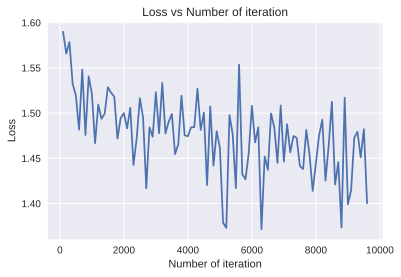

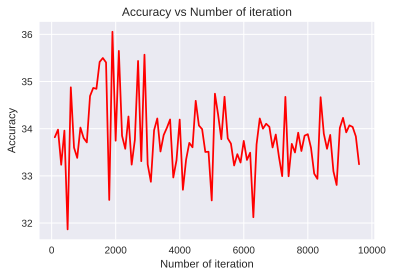

In [ ]:
draw_visualization(iteration_list, loss_list, accuracy_list)

**Prediction**

In [ ]:
_ = load_checkpoint('./model_many_conv_layers_best_checkpoint_v4', model_many_conv_layers, optimizer)

Loading checkpoint './model_many_conv_layers_best_checkpoint_v4'
Loaded checkpoint './model_many_conv_layers_best_checkpoint_v4' from iteration 1899


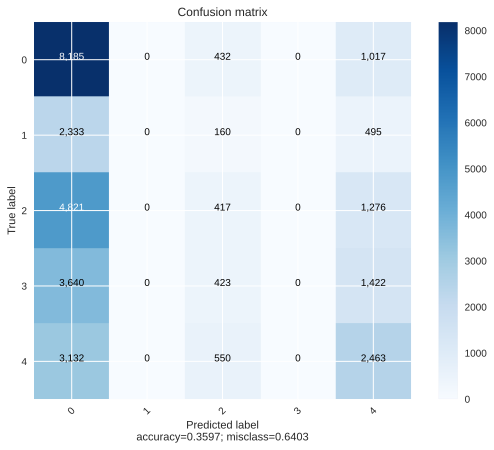

Accuracy: 0.35965 
Balanced accuracy: 0.26288 
Multiclass f1-score: 
    micro: 0.35965 
    macro: 0.19963 
    weighted: 0.25902


Classification report:

              precision    recall  f1-score   support

           0    0.37018   0.84960   0.51567      9634
           1    0.00000   0.00000   0.00000      2988
           2    0.21039   0.06402   0.09816      6514
           3    0.00000   0.00000   0.00000      5485
           4    0.36910   0.40081   0.38430      6145

    accuracy                        0.35965     30766
   macro avg    0.18993   0.26288   0.19963     30766
weighted avg    0.23418   0.35965   0.25902     30766



In [ ]:
preds = []

with torch.no_grad(): 
    for batch in iterate_minibatches(data_test, batch_size=128, shuffle=False, device=DEVICE): # batch_size=30766
        test_outputs = model_many_conv_layers(batch)
        predicted = torch.max(test_outputs.data,1)[1]
        preds.extend(predicted.detach().cpu().numpy())

calc_metrics(data_test['rank'].values, preds)

**Conclusion**

Metrics decrease smoothly. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.01787  
MAE:  0.04926  
LOSS:  0.07147  

### **Add more Conv. layers V2**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.Tanh(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.Dropout(p=0.25),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size *3, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3], dim=1)

        return self.final_predictor(joke_features).squeeze()

**Training**

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=32).to(DEVICE)
learning_rate = 0.09
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5554183721542358  Accuracy: 33.04124069213867 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5591927766799927  Accuracy: 34.76519775390625 %
Saving model and optimizer state at iteration 199 to ./many_conv_layers_best_checkpoint_v2
Iteration: 299  Loss: 1.5180169343948364  Accuracy: 33.33246612548828 %
Iteration: 399  Loss: 1.556442141532898  Accuracy: 35.26704406738281 %
Saving model and optimizer state at iteration 399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 499  Loss: 1.4954570531845093  Accuracy: 33.366268157958984 %
Iteration: 599  Loss: 1.5452030897140503  Accuracy: 34.69239044189453 %
Iteration: 699  Loss: 1.5264214277267456  Accuracy: 31.600706100463867 %
Iteration: 799  Loss: 1.5488303899765015  Accuracy: 33.34806823730469 %
Iteration: 899  Loss: 1.5422637462615967  Accuracy: 32.84362030029297 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5164607763290405  Accuracy: 35.41525650024414 %
Saving model and optimizer state at iteration 999 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1099  Loss: 1.5225290060043335  Accuracy: 34.98361587524414 %
Iteration: 1199  Loss: 1.5527898073196411  Accuracy: 33.75630569458008 %
Iteration: 1299  Loss: 1.5176124572753906  Accuracy: 33.940921783447266 %
Iteration: 1399  Loss: 1.5449748039245605  Accuracy: 35.831295013427734 %
Saving model and optimizer state at iteration 1399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1499  Loss: 1.4856116771697998  Accuracy: 35.92230224609375 %
Saving model and optimizer state at iteration 1499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1599  Loss: 1.521119475364685  Accuracy: 34.24515151977539 %
Iteration: 1699  Loss: 1.5159493684768677  Accuracy: 34.68199157714844 %
Iteration: 1799  Loss: 1.4969737529754639  Accuracy: 35.157833099365234 %
Iteration: 1899  Loss: 1.5034599304199219  Accuracy: 35.95350646972

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.46603262424469  Accuracy: 34.7599983215332 %
Iteration: 2099  Loss: 1.538069486618042  Accuracy: 33.55088424682617 %
Iteration: 2199  Loss: 1.5302770137786865  Accuracy: 33.1816520690918 %
Iteration: 2299  Loss: 1.488794207572937  Accuracy: 34.75479507446289 %
Iteration: 2399  Loss: 1.4963887929916382  Accuracy: 34.23994827270508 %
Iteration: 2499  Loss: 1.4919105768203735  Accuracy: 34.700191497802734 %
Iteration: 2599  Loss: 1.494605541229248  Accuracy: 35.373653411865234 %
Iteration: 2699  Loss: 1.492431879043579  Accuracy: 35.98991012573242 %
Saving model and optimizer state at iteration 2699 to ./many_conv_layers_best_checkpoint_v2
Iteration: 2799  Loss: 1.53299880027771  Accuracy: 32.7500114440918 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4151341915130615  Accuracy: 35.42045974731445 %
Iteration: 2999  Loss: 1.4670038223266602  Accuracy: 33.68349838256836 %
Iteration: 3099  Loss: 1.5501761436462402  Accuracy: 34.43236541748047 %
Iteration: 3199  Loss: 1.4551277160644531  Accuracy: 34.180145263671875 %
Iteration: 3299  Loss: 1.4823436737060547  Accuracy: 34.46876907348633 %
Iteration: 3399  Loss: 1.4518623352050781  Accuracy: 34.536376953125 %
Iteration: 3499  Loss: 1.4024951457977295  Accuracy: 34.362159729003906 %
Iteration: 3599  Loss: 1.4931838512420654  Accuracy: 35.589473724365234 %
Iteration: 3699  Loss: 1.465389370918274  Accuracy: 33.761505126953125 %
Iteration: 3799  Loss: 1.488406777381897  Accuracy: 34.9758186340332 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4740180969238281  Accuracy: 33.84471130371094 %
Iteration: 3999  Loss: 1.4564762115478516  Accuracy: 34.481773376464844 %
Iteration: 4099  Loss: 1.4751554727554321  Accuracy: 33.774505615234375 %
Iteration: 4199  Loss: 1.430645227432251  Accuracy: 34.78860092163086 %
Iteration: 4299  Loss: 1.4325802326202393  Accuracy: 34.36736297607422 %
Iteration: 4399  Loss: 1.4880539178848267  Accuracy: 34.41676712036133 %
Iteration: 4499  Loss: 1.4086023569107056  Accuracy: 33.63409423828125 %
Iteration: 4599  Loss: 1.5047502517700195  Accuracy: 35.07982635498047 %
Iteration: 4699  Loss: 1.4479539394378662  Accuracy: 33.35586929321289 %
Iteration: 4799  Loss: 1.5126057863235474  Accuracy: 35.32164764404297 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4385725259780884  Accuracy: 34.458370208740234 %
Iteration: 4999  Loss: 1.4311769008636475  Accuracy: 35.28524398803711 %
Iteration: 5099  Loss: 1.3734209537506104  Accuracy: 34.82240295410156 %
Iteration: 5199  Loss: 1.4756077527999878  Accuracy: 34.013729095458984 %
Iteration: 5299  Loss: 1.440959095954895  Accuracy: 33.84471130371094 %
Iteration: 5399  Loss: 1.5211012363433838  Accuracy: 34.08133316040039 %
Iteration: 5499  Loss: 1.4466280937194824  Accuracy: 33.353267669677734 %
Iteration: 5599  Loss: 1.4539943933486938  Accuracy: 33.327266693115234 %
Iteration: 5699  Loss: 1.4886844158172607  Accuracy: 33.76670455932617 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.3972446918487549  Accuracy: 33.618492126464844 %


KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=64).to(DEVICE)
learning_rate = 0.07
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.4993911981582642  Accuracy: 31.582504272460938 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5089815855026245  Accuracy: 33.52748489379883 %
Saving model and optimizer state at iteration 199 to ./many_conv_layers_best_checkpoint_v2
Iteration: 299  Loss: 1.59071683883667  Accuracy: 34.26074981689453 %
Saving model and optimizer state at iteration 299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 399  Loss: 1.5364246368408203  Accuracy: 34.892608642578125 %
Saving model and optimizer state at iteration 399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 499  Loss: 1.469923973083496  Accuracy: 33.82651138305664 %
Iteration: 599  Loss: 1.5097624063491821  Accuracy: 34.61958312988281 %
Iteration: 699  Loss: 1.500786304473877  Accuracy: 32.921627044677734 %
Iteration: 799  Loss: 1.5435298681259155  Accuracy: 33.52488327026367 %
Iteration: 899  Loss: 1.498369574546814  Accuracy: 35.995109558

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4650306701660156  Accuracy: 33.433876037597656 %
Iteration: 1099  Loss: 1.547903060913086  Accuracy: 34.79899978637695 %
Iteration: 1199  Loss: 1.5395195484161377  Accuracy: 33.90971755981445 %
Iteration: 1299  Loss: 1.4847005605697632  Accuracy: 33.75890350341797 %
Iteration: 1399  Loss: 1.527152419090271  Accuracy: 33.50408172607422 %
Iteration: 1499  Loss: 1.552011251449585  Accuracy: 34.603981018066406 %
Iteration: 1599  Loss: 1.5024123191833496  Accuracy: 35.83389663696289 %
Iteration: 1699  Loss: 1.4987269639968872  Accuracy: 34.398563385009766 %
Iteration: 1799  Loss: 1.4820412397384644  Accuracy: 33.662696838378906 %
Iteration: 1899  Loss: 1.5603065490722656  Accuracy: 36.021114349365234 %
Saving model and optimizer state at iteration 1899 to ./many_conv_layers_best_checkpoint_v2
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.46726393699646  Accuracy: 35.85209655761719 %
Iteration: 2099  Loss: 1.492325782775879  Accuracy: 33.61069107055664 %
Iteration: 2199  Loss: 1.494869589805603  Accuracy: 32.976234436035156 %
Iteration: 2299  Loss: 1.5292809009552002  Accuracy: 32.58619689941406 %
Iteration: 2399  Loss: 1.4702839851379395  Accuracy: 34.95761489868164 %
Iteration: 2499  Loss: 1.5095099210739136  Accuracy: 33.53528594970703 %
Iteration: 2599  Loss: 1.5316866636276245  Accuracy: 34.21394729614258 %
Iteration: 2699  Loss: 1.499497890472412  Accuracy: 34.40116500854492 %
Iteration: 2799  Loss: 1.5493370294570923  Accuracy: 34.56758117675781 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4529199600219727  Accuracy: 33.60289001464844 %
Iteration: 2999  Loss: 1.4669711589813232  Accuracy: 34.255550384521484 %
Iteration: 3099  Loss: 1.44772207736969  Accuracy: 34.507774353027344 %
Iteration: 3199  Loss: 1.422110676765442  Accuracy: 32.9398307800293 %
Iteration: 3299  Loss: 1.4448051452636719  Accuracy: 33.96952438354492 %


KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=32).to(DEVICE)
learning_rate = 0.08
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.592122197151184  Accuracy: 33.63669204711914 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v1
Iteration: 199  Loss: 1.529117226600647  Accuracy: 31.99854278564453 %
Iteration: 299  Loss: 1.519984245300293  Accuracy: 32.57839584350586 %
Iteration: 399  Loss: 1.5476230382919312  Accuracy: 33.33766555786133 %
Iteration: 499  Loss: 1.5246081352233887  Accuracy: 33.35586929321289 %
Iteration: 599  Loss: 1.4666945934295654  Accuracy: 34.06833267211914 %
Saving model and optimizer state at iteration 599 to ./many_conv_layers_best_checkpoint_v1
Iteration: 699  Loss: 1.5194963216781616  Accuracy: 33.8551139831543 %
Iteration: 799  Loss: 1.605011224746704  Accuracy: 34.93681335449219 %
Saving model and optimizer state at iteration 799 to ./many_conv_layers_best_checkpoint_v1
Iteration: 899  Loss: 1.5242156982421875  Accuracy: 33.90971755981445 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.525991678237915  Accuracy: 33.14264678955078 %
Iteration: 1099  Loss: 1.5049620866775513  Accuracy: 34.13594055175781 %
Iteration: 1199  Loss: 1.5193917751312256  Accuracy: 34.85880661010742 %
Iteration: 1299  Loss: 1.4983208179473877  Accuracy: 34.65338897705078 %
Iteration: 1399  Loss: 1.5272666215896606  Accuracy: 32.75521469116211 %
Iteration: 1499  Loss: 1.478143334388733  Accuracy: 32.59919738769531 %
Iteration: 1599  Loss: 1.5087990760803223  Accuracy: 33.797908782958984 %
Iteration: 1699  Loss: 1.4929046630859375  Accuracy: 35.579071044921875 %
Saving model and optimizer state at iteration 1699 to ./many_conv_layers_best_checkpoint_v1
Iteration: 1799  Loss: 1.450637698173523  Accuracy: 34.856204986572266 %
Iteration: 1899  Loss: 1.565354585647583  Accuracy: 35.28264617919922 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.476271390914917  Accuracy: 34.96281433105469 %
Iteration: 2099  Loss: 1.4816967248916626  Accuracy: 32.33657455444336 %
Iteration: 2199  Loss: 1.4744467735290527  Accuracy: 34.02153015136719 %
Iteration: 2299  Loss: 1.4787859916687012  Accuracy: 35.722084045410156 %
Saving model and optimizer state at iteration 2299 to ./many_conv_layers_best_checkpoint_v1
Iteration: 2399  Loss: 1.506895899772644  Accuracy: 35.768890380859375 %
Saving model and optimizer state at iteration 2399 to ./many_conv_layers_best_checkpoint_v1
Iteration: 2499  Loss: 1.4774150848388672  Accuracy: 34.094337463378906 %
Iteration: 2599  Loss: 1.5246447324752808  Accuracy: 34.85880661010742 %
Iteration: 2699  Loss: 1.4837472438812256  Accuracy: 33.62629318237305 %
Iteration: 2799  Loss: 1.4768872261047363  Accuracy: 34.819801330566406 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4554616212844849  Accuracy: 32.96063232421875 %
Iteration: 2999  Loss: 1.5166147947311401  Accuracy: 33.545684814453125 %
Iteration: 3099  Loss: 1.4980823993682861  Accuracy: 33.09584426879883 %
Iteration: 3199  Loss: 1.5226885080337524  Accuracy: 33.89931869506836 %
Iteration: 3299  Loss: 1.4983211755752563  Accuracy: 33.1816520690918 %
Iteration: 3399  Loss: 1.455553650856018  Accuracy: 32.93722915649414 %
Iteration: 3499  Loss: 1.4557271003723145  Accuracy: 32.85142135620117 %
Iteration: 3599  Loss: 1.5178184509277344  Accuracy: 33.101043701171875 %
Iteration: 3699  Loss: 1.5086233615875244  Accuracy: 34.46876907348633 %
Iteration: 3799  Loss: 1.4569947719573975  Accuracy: 34.14113998413086 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4003783464431763  Accuracy: 33.860313415527344 %
Iteration: 3999  Loss: 1.4740571975708008  Accuracy: 33.10624694824219 %
Iteration: 4099  Loss: 1.3540699481964111  Accuracy: 33.94352340698242 %
Iteration: 4199  Loss: 1.418933629989624  Accuracy: 34.51297378540039 %
Iteration: 4299  Loss: 1.4366511106491089  Accuracy: 33.22065734863281 %
Iteration: 4399  Loss: 1.459993839263916  Accuracy: 34.12294006347656 %
Iteration: 4499  Loss: 1.4748226404190063  Accuracy: 33.60029220581055 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_bn_best_checkpoint_v2', model_bn, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_bn, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

Metrics decrease smoothly. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.01706  
MAE:  0.048  
LOSS:  0.06823  


### **CNN V3 (add more Conv. layers & MaxPooling)**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.joke_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features_4 = self.joke_encoder_4(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3, joke_features_4], dim=1)

        return self.final_predictor(joke_features).squeeze()




In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=128).to(DEVICE) # 128
learning_rate = 0.04
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5429927110671997  Accuracy: 32.593997955322266 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.543977975845337  Accuracy: 35.2280387878418 %
Saving model and optimizer state at iteration 199 to ./many_conv_layers_best_checkpoint_v2
Iteration: 299  Loss: 1.509831190109253  Accuracy: 35.722084045410156 %
Saving model and optimizer state at iteration 299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 399  Loss: 1.5065861940383911  Accuracy: 35.576473236083984 %
Iteration: 499  Loss: 1.529908537864685  Accuracy: 35.58427429199219 %
Iteration: 599  Loss: 1.5645809173583984  Accuracy: 32.958030700683594 %
Iteration: 699  Loss: 1.5128434896469116  Accuracy: 36.37214660644531 %
Saving model and optimizer state at iteration 699 to ./many_conv_layers_best_checkpoint_v2
Iteration: 799  Loss: 1.5247888565063477  Accuracy: 35.828697204589844 %
Iteration: 899  Loss: 1.5344535112380981  Accuracy: 36.626968

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.446517825126648  Accuracy: 36.5567626953125 %
Iteration: 1099  Loss: 1.491233229637146  Accuracy: 35.66228103637695 %
Iteration: 1199  Loss: 1.481853723526001  Accuracy: 35.66748046875 %
Iteration: 1299  Loss: 1.4874681234359741  Accuracy: 36.37734603881836 %
Iteration: 1399  Loss: 1.4158070087432861  Accuracy: 35.563472747802734 %
Iteration: 1499  Loss: 1.54744553565979  Accuracy: 35.831295013427734 %
Iteration: 1599  Loss: 1.4267854690551758  Accuracy: 36.89219284057617 %
Saving model and optimizer state at iteration 1599 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1699  Loss: 1.4577610492706299  Accuracy: 35.53226852416992 %
Iteration: 1799  Loss: 1.4543944597244263  Accuracy: 36.567161560058594 %
Iteration: 1899  Loss: 1.490792989730835  Accuracy: 36.75178146362305 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4519999027252197  Accuracy: 35.781890869140625 %
Iteration: 2099  Loss: 1.496247410774231  Accuracy: 35.19163513183594 %
Iteration: 2199  Loss: 1.4051944017410278  Accuracy: 36.20573043823242 %
Iteration: 2299  Loss: 1.49186110496521  Accuracy: 36.13032150268555 %
Iteration: 2399  Loss: 1.4493584632873535  Accuracy: 35.683082580566406 %
Iteration: 2499  Loss: 1.3772408962249756  Accuracy: 36.164127349853516 %
Iteration: 2599  Loss: 1.4893454313278198  Accuracy: 32.98403549194336 %
Iteration: 2699  Loss: 1.5239988565444946  Accuracy: 35.168235778808594 %
Iteration: 2799  Loss: 1.4111385345458984  Accuracy: 35.97690963745117 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.3667832612991333  Accuracy: 35.46986389160156 %
Iteration: 2999  Loss: 1.3724141120910645  Accuracy: 36.418949127197266 %
Iteration: 3099  Loss: 1.419309139251709  Accuracy: 35.07462692260742 %
Iteration: 3199  Loss: 1.396146535873413  Accuracy: 35.88330078125 %
Iteration: 3299  Loss: 1.4527573585510254  Accuracy: 34.44016647338867 %
Iteration: 3399  Loss: 1.4040286540985107  Accuracy: 35.09803009033203 %
Iteration: 3499  Loss: 1.4669713973999023  Accuracy: 33.964324951171875 %
Iteration: 3599  Loss: 1.4547533988952637  Accuracy: 34.23474884033203 %
Iteration: 3699  Loss: 1.413629174232483  Accuracy: 35.53487014770508 %
Iteration: 3799  Loss: 1.4384093284606934  Accuracy: 36.37734603881836 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.3444647789001465  Accuracy: 35.34244918823242 %
Iteration: 3999  Loss: 1.36590576171875  Accuracy: 36.096519470214844 %
Iteration: 4099  Loss: 1.4062482118606567  Accuracy: 34.965415954589844 %
Iteration: 4199  Loss: 1.3664624691009521  Accuracy: 33.88631820678711 %
Iteration: 4299  Loss: 1.4965591430664062  Accuracy: 36.275936126708984 %
Iteration: 4399  Loss: 1.4375622272491455  Accuracy: 35.397056579589844 %
Iteration: 4499  Loss: 1.3931636810302734  Accuracy: 33.22845458984375 %
Iteration: 4599  Loss: 1.414768934249878  Accuracy: 34.73139572143555 %
Iteration: 4699  Loss: 1.4056094884872437  Accuracy: 36.200531005859375 %
Iteration: 4799  Loss: 1.3672699928283691  Accuracy: 33.30906295776367 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.482005000114441  Accuracy: 34.69239044189453 %
Iteration: 4999  Loss: 1.3986116647720337  Accuracy: 34.92121124267578 %
Iteration: 5099  Loss: 1.377648949623108  Accuracy: 34.65858840942383 %
Iteration: 5199  Loss: 1.4273988008499146  Accuracy: 34.69758987426758 %
Iteration: 5299  Loss: 1.3090826272964478  Accuracy: 35.6596794128418 %
Iteration: 5399  Loss: 1.4206032752990723  Accuracy: 36.010711669921875 %
Iteration: 5499  Loss: 1.3780701160430908  Accuracy: 34.7859992980957 %
Iteration: 5599  Loss: 1.4390517473220825  Accuracy: 34.713191986083984 %
Iteration: 5699  Loss: 1.4160064458847046  Accuracy: 34.41936492919922 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.3053086996078491  Accuracy: 34.01892852783203 %
Iteration: 5899  Loss: 1.3591684103012085  Accuracy: 35.23064041137695 %


KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=128).to(DEVICE) # 128
learning_rate = 0.06
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5184944868087769  Accuracy: 33.04383850097656 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5099828243255615  Accuracy: 34.536376953125 %
Saving model and optimizer state at iteration 199 to ./many_conv_layers_best_checkpoint_v2
Iteration: 299  Loss: 1.5526090860366821  Accuracy: 34.9602165222168 %
Saving model and optimizer state at iteration 299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 399  Loss: 1.5139724016189575  Accuracy: 34.59878158569336 %
Iteration: 499  Loss: 1.5530933141708374  Accuracy: 35.55567169189453 %
Saving model and optimizer state at iteration 499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 599  Loss: 1.4970742464065552  Accuracy: 36.330543518066406 %
Saving model and optimizer state at iteration 599 to ./many_conv_layers_best_checkpoint_v2
Iteration: 699  Loss: 1.5138801336288452  Accuracy: 36.15632629394531 %
Iteration: 799  Loss: 1.5381699800491333  Acc

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4859628677368164  Accuracy: 34.5103759765625 %
Iteration: 1099  Loss: 1.51214599609375  Accuracy: 35.57387161254883 %
Iteration: 1199  Loss: 1.5498714447021484  Accuracy: 34.978416442871094 %
Iteration: 1299  Loss: 1.512479543685913  Accuracy: 34.88220977783203 %
Iteration: 1399  Loss: 1.5049347877502441  Accuracy: 36.478755950927734 %
Saving model and optimizer state at iteration 1399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1499  Loss: 1.4768445491790771  Accuracy: 36.203128814697266 %
Iteration: 1599  Loss: 1.5096259117126465  Accuracy: 36.21873092651367 %
Iteration: 1699  Loss: 1.4652661085128784  Accuracy: 35.4854621887207 %
Iteration: 1799  Loss: 1.4952045679092407  Accuracy: 35.57387161254883 %
Iteration: 1899  Loss: 1.503100037574768  Accuracy: 36.1589241027832 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.454422950744629  Accuracy: 35.38925552368164 %
Iteration: 2099  Loss: 1.495489239692688  Accuracy: 34.942012786865234 %
Iteration: 2199  Loss: 1.4887210130691528  Accuracy: 34.385562896728516 %
Iteration: 2299  Loss: 1.4739819765090942  Accuracy: 35.579071044921875 %
Iteration: 2399  Loss: 1.4979684352874756  Accuracy: 36.05231475830078 %
Iteration: 2499  Loss: 1.5029771327972412  Accuracy: 36.50995635986328 %
Saving model and optimizer state at iteration 2499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 2599  Loss: 1.4974883794784546  Accuracy: 36.22133255004883 %
Iteration: 2699  Loss: 1.4024975299835205  Accuracy: 35.77408981323242 %
Iteration: 2799  Loss: 1.484535813331604  Accuracy: 34.54937744140625 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4281593561172485  Accuracy: 36.25513458251953 %
Iteration: 2999  Loss: 1.475263237953186  Accuracy: 35.83649444580078 %
Iteration: 3099  Loss: 1.4172029495239258  Accuracy: 35.57387161254883 %
Iteration: 3199  Loss: 1.5313466787338257  Accuracy: 35.86249923706055 %
Iteration: 3299  Loss: 1.4920856952667236  Accuracy: 35.39445495605469 %
Iteration: 3399  Loss: 1.4618092775344849  Accuracy: 35.62327575683594 %
Iteration: 3499  Loss: 1.3842283487319946  Accuracy: 35.32944869995117 %
Iteration: 3599  Loss: 1.4350099563598633  Accuracy: 34.70279312133789 %
Iteration: 3699  Loss: 1.4013688564300537  Accuracy: 35.7012825012207 %
Iteration: 3799  Loss: 1.4230241775512695  Accuracy: 36.429351806640625 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.3881527185440063  Accuracy: 35.98991012573242 %
Iteration: 3999  Loss: 1.4485079050064087  Accuracy: 35.11103057861328 %
Iteration: 4099  Loss: 1.427366852760315  Accuracy: 36.166725158691406 %
Iteration: 4199  Loss: 1.5317963361740112  Accuracy: 34.35696029663086 %
Iteration: 4299  Loss: 1.4045897722244263  Accuracy: 34.48697280883789 %
Iteration: 4399  Loss: 1.4734665155410767  Accuracy: 35.53487014770508 %
Iteration: 4499  Loss: 1.479860782623291  Accuracy: 36.12252426147461 %


KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=64).to(DEVICE) # 128
learning_rate = 0.06 # 0.08
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5629147291183472  Accuracy: 34.588382720947266 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5404173135757446  Accuracy: 35.28004455566406 %
Saving model and optimizer state at iteration 199 to ./many_conv_layers_best_checkpoint_v2
Iteration: 299  Loss: 1.526324987411499  Accuracy: 35.251441955566406 %
Iteration: 399  Loss: 1.531347393989563  Accuracy: 34.1385383605957 %
Iteration: 499  Loss: 1.4680933952331543  Accuracy: 35.987308502197266 %
Saving model and optimizer state at iteration 499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 599  Loss: 1.541900873184204  Accuracy: 36.070518493652344 %
Saving model and optimizer state at iteration 599 to ./many_conv_layers_best_checkpoint_v2
Iteration: 699  Loss: 1.5114784240722656  Accuracy: 35.99510955810547 %
Iteration: 799  Loss: 1.5554068088531494  Accuracy: 36.01851272583008 %
Iteration: 899  Loss: 1.4937821626663208  Accuracy: 36.3019409

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4552254676818848  Accuracy: 35.4256591796875 %
Iteration: 1099  Loss: 1.484863042831421  Accuracy: 35.49586486816406 %
Iteration: 1199  Loss: 1.473954677581787  Accuracy: 34.63518524169922 %
Iteration: 1299  Loss: 1.4762194156646729  Accuracy: 36.3409423828125 %
Saving model and optimizer state at iteration 1299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1399  Loss: 1.452318787574768  Accuracy: 35.298248291015625 %
Iteration: 1499  Loss: 1.5247197151184082  Accuracy: 35.373653411865234 %
Iteration: 1599  Loss: 1.4471008777618408  Accuracy: 36.10432052612305 %
Iteration: 1699  Loss: 1.51490318775177  Accuracy: 35.59207534790039 %
Iteration: 1799  Loss: 1.5350303649902344  Accuracy: 36.647769927978516 %
Saving model and optimizer state at iteration 1799 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1899  Loss: 1.5039596557617188  Accuracy: 36.80378341674805 %
Saving model and optimizer state at iteration 1899 to ./many_conv_layers_best_checkpoint_v2

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4538207054138184  Accuracy: 35.58687210083008 %
Iteration: 2099  Loss: 1.4771854877471924  Accuracy: 35.16303253173828 %
Iteration: 2199  Loss: 1.4367941617965698  Accuracy: 35.87289810180664 %
Iteration: 2299  Loss: 1.4826029539108276  Accuracy: 36.28113555908203 %
Iteration: 2399  Loss: 1.4222878217697144  Accuracy: 35.89630126953125 %
Iteration: 2499  Loss: 1.4657692909240723  Accuracy: 36.611366271972656 %
Iteration: 2599  Loss: 1.4203789234161377  Accuracy: 35.924903869628906 %
Iteration: 2699  Loss: 1.4919819831848145  Accuracy: 35.157833099365234 %
Iteration: 2799  Loss: 1.503644585609436  Accuracy: 35.31644821166992 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4098438024520874  Accuracy: 35.480262756347656 %
Iteration: 2999  Loss: 1.5079247951507568  Accuracy: 35.157833099365234 %
Iteration: 3099  Loss: 1.4129648208618164  Accuracy: 36.13812255859375 %
Iteration: 3199  Loss: 1.4755321741104126  Accuracy: 35.24104309082031 %
Iteration: 3299  Loss: 1.4623370170593262  Accuracy: 35.794891357421875 %
Iteration: 3399  Loss: 1.4451926946640015  Accuracy: 36.073116302490234 %
Iteration: 3499  Loss: 1.4596965312957764  Accuracy: 34.663787841796875 %
Iteration: 3599  Loss: 1.4639112949371338  Accuracy: 35.9015007019043 %
Iteration: 3699  Loss: 1.4547243118286133  Accuracy: 35.63107681274414 %
Iteration: 3799  Loss: 1.4423096179962158  Accuracy: 35.6752815246582 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.3895885944366455  Accuracy: 35.6492805480957 %
Iteration: 3999  Loss: 1.416739583015442  Accuracy: 34.41936492919922 %
Iteration: 4099  Loss: 1.4420242309570312  Accuracy: 35.13703155517578 %
Iteration: 4199  Loss: 1.4354983568191528  Accuracy: 33.93572235107422 %
Iteration: 4299  Loss: 1.4067237377166748  Accuracy: 35.23064041137695 %
Iteration: 4399  Loss: 1.3990811109542847  Accuracy: 36.1173210144043 %
Iteration: 4499  Loss: 1.406493902206421  Accuracy: 35.72468566894531 %
Iteration: 4599  Loss: 1.387319803237915  Accuracy: 35.92750549316406 %
Iteration: 4699  Loss: 1.481597900390625  Accuracy: 34.601383209228516 %
Iteration: 4799  Loss: 1.4900277853012085  Accuracy: 35.66748046875 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=64).to(DEVICE) # 32 
learning_rate = 0.08 # 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.649899959564209  Accuracy: 35.14743423461914 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5188357830047607  Accuracy: 34.51297378540039 %
Iteration: 299  Loss: 1.5335286855697632  Accuracy: 33.784908294677734 %
Iteration: 399  Loss: 1.4731998443603516  Accuracy: 34.520774841308594 %
Iteration: 499  Loss: 1.5176879167556763  Accuracy: 35.72988510131836 %
Saving model and optimizer state at iteration 499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 599  Loss: 1.5393754243850708  Accuracy: 34.7183952331543 %
Iteration: 699  Loss: 1.496899962425232  Accuracy: 35.670082092285156 %
Iteration: 799  Loss: 1.506227731704712  Accuracy: 35.50886535644531 %
Iteration: 899  Loss: 1.4849697351455688  Accuracy: 35.792293548583984 %
Saving model and optimizer state at iteration 899 to ./many_conv_layers_best_checkpoint_v2
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.585634469985962  Accuracy: 34.46356964111328 %
Iteration: 1099  Loss: 1.5006344318389893  Accuracy: 34.11773681640625 %
Iteration: 1199  Loss: 1.514271855354309  Accuracy: 35.035621643066406 %
Iteration: 1299  Loss: 1.4987564086914062  Accuracy: 34.5025749206543 %
Iteration: 1399  Loss: 1.575433373451233  Accuracy: 34.83280563354492 %
Iteration: 1499  Loss: 1.5207231044769287  Accuracy: 36.07831954956055 %
Saving model and optimizer state at iteration 1499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1599  Loss: 1.5077356100082397  Accuracy: 34.98101806640625 %
Iteration: 1699  Loss: 1.5415147542953491  Accuracy: 36.60616683959961 %
Saving model and optimizer state at iteration 1699 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1799  Loss: 1.4646937847137451  Accuracy: 35.7012825012207 %
Iteration: 1899  Loss: 1.4949325323104858  Accuracy: 34.82240295410156 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5147844552993774  Accuracy: 34.95761489868164 %
Iteration: 2099  Loss: 1.474453091621399  Accuracy: 35.048622131347656 %
Iteration: 2199  Loss: 1.5170456171035767  Accuracy: 35.96910858154297 %
Iteration: 2299  Loss: 1.4575682878494263  Accuracy: 36.023712158203125 %
Iteration: 2399  Loss: 1.489428162574768  Accuracy: 35.63107681274414 %
Iteration: 2499  Loss: 1.5590548515319824  Accuracy: 34.0709342956543 %
Iteration: 2599  Loss: 1.4783027172088623  Accuracy: 35.709083557128906 %
Iteration: 2699  Loss: 1.4808554649353027  Accuracy: 35.638877868652344 %
Iteration: 2799  Loss: 1.4830561876296997  Accuracy: 34.08133316040039 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4014084339141846  Accuracy: 36.127723693847656 %
Iteration: 2999  Loss: 1.4600574970245361  Accuracy: 33.97212600708008 %
Iteration: 3099  Loss: 1.4727015495300293  Accuracy: 34.42976760864258 %
Iteration: 3199  Loss: 1.4185948371887207  Accuracy: 35.350250244140625 %
Iteration: 3299  Loss: 1.4933829307556152  Accuracy: 35.77928924560547 %
Iteration: 3399  Loss: 1.4487942457199097  Accuracy: 34.77299880981445 %
Iteration: 3499  Loss: 1.4465404748916626  Accuracy: 35.44906234741211 %
Iteration: 3599  Loss: 1.46916925907135  Accuracy: 33.70429992675781 %
Iteration: 3699  Loss: 1.466103196144104  Accuracy: 35.758487701416016 %
Iteration: 3799  Loss: 1.4823263883590698  Accuracy: 34.65598678588867 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4167410135269165  Accuracy: 35.03822326660156 %
Iteration: 3999  Loss: 1.4628167152404785  Accuracy: 34.978416442871094 %
Iteration: 4099  Loss: 1.4370607137680054  Accuracy: 35.300846099853516 %
Iteration: 4199  Loss: 1.4918947219848633  Accuracy: 35.02522277832031 %
Iteration: 4299  Loss: 1.4005730152130127  Accuracy: 34.853607177734375 %
Iteration: 4399  Loss: 1.478513479232788  Accuracy: 35.95610809326172 %


KeyboardInterrupt: ignored

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=32).to(DEVICE) # 32 
learning_rate = 0.08 # 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.53396475315094  Accuracy: 34.039730072021484 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5725468397140503  Accuracy: 32.78901672363281 %
Iteration: 299  Loss: 1.4925103187561035  Accuracy: 34.66638946533203 %
Saving model and optimizer state at iteration 299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 399  Loss: 1.4944849014282227  Accuracy: 35.480262756347656 %
Saving model and optimizer state at iteration 399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 499  Loss: 1.542759656906128  Accuracy: 35.046024322509766 %
Iteration: 599  Loss: 1.4909950494766235  Accuracy: 35.59727478027344 %
Saving model and optimizer state at iteration 599 to ./many_conv_layers_best_checkpoint_v2
Iteration: 699  Loss: 1.4498933553695679  Accuracy: 35.32685089111328 %
Iteration: 799  Loss: 1.5032728910446167  Accuracy: 35.984710693359375 %
Saving model and optimizer state at iteration 799 to ./many_c

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4684299230575562  Accuracy: 35.77669143676758 %
Iteration: 1099  Loss: 1.480929970741272  Accuracy: 35.42045974731445 %
Iteration: 1199  Loss: 1.4701226949691772  Accuracy: 35.51146697998047 %
Iteration: 1299  Loss: 1.4649178981781006  Accuracy: 35.75328826904297 %
Iteration: 1399  Loss: 1.5187461376190186  Accuracy: 36.164127349853516 %
Saving model and optimizer state at iteration 1399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1499  Loss: 1.5298372507095337  Accuracy: 36.06271743774414 %
Iteration: 1599  Loss: 1.495202898979187  Accuracy: 35.90670394897461 %
Iteration: 1699  Loss: 1.5482759475708008  Accuracy: 36.431949615478516 %
Saving model and optimizer state at iteration 1699 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1799  Loss: 1.4826127290725708  Accuracy: 35.74028778076172 %
Iteration: 1899  Loss: 1.5418990850448608  Accuracy: 36.11992263793945 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4914342164993286  Accuracy: 35.2098388671875 %
Iteration: 2099  Loss: 1.513291597366333  Accuracy: 35.94570541381836 %
Iteration: 2199  Loss: 1.467389464378357  Accuracy: 35.347652435302734 %
Iteration: 2299  Loss: 1.5122804641723633  Accuracy: 35.87810134887695 %
Iteration: 2399  Loss: 1.4893227815628052  Accuracy: 36.23173141479492 %
Iteration: 2499  Loss: 1.416926383972168  Accuracy: 35.264442443847656 %
Iteration: 2599  Loss: 1.424623727798462  Accuracy: 35.24104309082031 %
Iteration: 2699  Loss: 1.5185025930404663  Accuracy: 35.32944869995117 %
Iteration: 2799  Loss: 1.4463021755218506  Accuracy: 36.46315383911133 %
Saving model and optimizer state at iteration 2799 to ./many_conv_layers_best_checkpoint_v2
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4413107633590698  Accuracy: 35.181236267089844 %
Iteration: 2999  Loss: 1.4351626634597778  Accuracy: 35.09022903442383 %
Iteration: 3099  Loss: 1.4567800760269165  Accuracy: 35.83389663696289 %
Iteration: 3199  Loss: 1.4643197059631348  Accuracy: 34.536376953125 %
Iteration: 3299  Loss: 1.4801453351974487  Accuracy: 36.22913360595703 %
Iteration: 3399  Loss: 1.4742159843444824  Accuracy: 35.745487213134766 %
Iteration: 3499  Loss: 1.418652892112732  Accuracy: 35.71168518066406 %
Iteration: 3599  Loss: 1.4365959167480469  Accuracy: 35.36845397949219 %
Iteration: 3699  Loss: 1.4201740026474  Accuracy: 36.41114807128906 %
Iteration: 3799  Loss: 1.5108716487884521  Accuracy: 35.89630126953125 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.3593031167984009  Accuracy: 35.6336784362793 %
Iteration: 3999  Loss: 1.4507458209991455  Accuracy: 35.399654388427734 %
Iteration: 4099  Loss: 1.4800138473510742  Accuracy: 33.66789627075195 %
Iteration: 4199  Loss: 1.444738507270813  Accuracy: 36.12252426147461 %
Iteration: 4299  Loss: 1.4598538875579834  Accuracy: 35.45166015625 %
Iteration: 4399  Loss: 1.39629328250885  Accuracy: 35.68828201293945 %
Iteration: 4499  Loss: 1.491261601448059  Accuracy: 35.66228103637695 %
Iteration: 4599  Loss: 1.3717485666275024  Accuracy: 35.58427429199219 %
Iteration: 4699  Loss: 1.4794634580612183  Accuracy: 35.602474212646484 %
Iteration: 4799  Loss: 1.4689842462539673  Accuracy: 34.7443962097168 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.3982925415039062  Accuracy: 35.553070068359375 %
Iteration: 4999  Loss: 1.3790620565414429  Accuracy: 35.01222229003906 %
Iteration: 5099  Loss: 1.434041976928711  Accuracy: 34.291954040527344 %
Iteration: 5199  Loss: 1.3438341617584229  Accuracy: 35.732486724853516 %
Iteration: 5299  Loss: 1.3836082220077515  Accuracy: 34.385562896728516 %
Iteration: 5399  Loss: 1.4304137229919434  Accuracy: 35.03822326660156 %
Iteration: 5499  Loss: 1.4782780408859253  Accuracy: 34.66118621826172 %
Iteration: 5599  Loss: 1.4046212434768677  Accuracy: 34.780799865722656 %
Iteration: 5699  Loss: 1.4169148206710815  Accuracy: 35.44906234741211 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_best_checkpoint_v4', model_cnn_v4, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_cnn_v4, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.05892
MAE:  0.10197
LOSS:  0.23567


### **General conclusion №1**

All models behave as similar as possible, however, the training time differs. As the layers and parameters of the model increased, the training time significantly increased. Using MaxPooling, the number of trained parameters was reduced, and the training went faster. Adding Layer Normalization layers, the model gave the best result on the test data.

# **🚩  2. Pooling слои стандартные**

*   Максимум по временной компоненте (незавимисо для каждой фичи)
*   Среднее по временной компоненте (исключая PAD символы)


## **1) Pooling слой:** 

This layer reduces the size of the feature map, works like Conv. layer. The basic idea is that we divide the output layers into subsections and calculate the value that best reflects the output data. The effectiveness of this approach lies in the fact that in this way we help the model to study higher-order data while reducing the number of parameters. Shows if there is a feature in this particular zone.

## **2) Взять максимум по временной компоненте (незавимисо для каждой фичи)**

In [ ]:
class MaxTimePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            MaxTimePooling(),
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            MaxTimePooling(),
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            MaxTimePooling(),
        )

        self.joke_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            MaxTimePooling(),
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features_4 = self.joke_encoder_4(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3, joke_features_4], dim=1)

        return self.final_predictor(joke_features).squeeze()

**Training**

In [ ]:
model_many_conv_layers = JokeRankPredictor(hid_size=128).to(DEVICE) # 32
learning_rate = 0.008
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./many_conv_layers_best_checkpoint_v2",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5078071355819702  Accuracy: 35.01742172241211 %
Saving model and optimizer state at iteration 99 to ./many_conv_layers_best_checkpoint_v2
Iteration: 199  Loss: 1.5596193075180054  Accuracy: 34.42976760864258 %
Iteration: 299  Loss: 1.5587512254714966  Accuracy: 35.48286437988281 %
Saving model and optimizer state at iteration 299 to ./many_conv_layers_best_checkpoint_v2
Iteration: 399  Loss: 1.5599267482757568  Accuracy: 35.49846649169922 %
Saving model and optimizer state at iteration 399 to ./many_conv_layers_best_checkpoint_v2
Iteration: 499  Loss: 1.5518306493759155  Accuracy: 35.657081604003906 %
Saving model and optimizer state at iteration 499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 599  Loss: 1.4910680055618286  Accuracy: 35.35805130004883 %
Iteration: 699  Loss: 1.5026097297668457  Accuracy: 36.127723693847656 %
Saving model and optimizer state at iteration 699 to ./many_conv_layers_best_checkpoint_v2
Iteration: 799  Loss: 1.4821497201919556 

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4654591083526611  Accuracy: 36.567161560058594 %
Saving model and optimizer state at iteration 999 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1099  Loss: 1.4787781238555908  Accuracy: 34.58058166503906 %
Iteration: 1199  Loss: 1.5016189813613892  Accuracy: 36.40074920654297 %
Iteration: 1299  Loss: 1.4936834573745728  Accuracy: 35.9093017578125 %
Iteration: 1399  Loss: 1.5104470252990723  Accuracy: 34.942012786865234 %
Iteration: 1499  Loss: 1.4962488412857056  Accuracy: 36.81678771972656 %
Saving model and optimizer state at iteration 1499 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1599  Loss: 1.5264289379119873  Accuracy: 36.01591110229492 %
Iteration: 1699  Loss: 1.4985381364822388  Accuracy: 35.50886535644531 %
Iteration: 1799  Loss: 1.4927866458892822  Accuracy: 37.14961624145508 %
Saving model and optimizer state at iteration 1799 to ./many_conv_layers_best_checkpoint_v2
Iteration: 1899  Loss: 1.4663234949111938  Accuracy: 35.969108581542

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4764670133590698  Accuracy: 33.6470947265625 %
Iteration: 2099  Loss: 1.4311364889144897  Accuracy: 36.76218032836914 %
Iteration: 2199  Loss: 1.4326800107955933  Accuracy: 35.09282684326172 %
Iteration: 2299  Loss: 1.4882326126098633  Accuracy: 35.44646072387695 %
Iteration: 2399  Loss: 1.492621660232544  Accuracy: 36.7647819519043 %
Iteration: 2499  Loss: 1.5052424669265747  Accuracy: 37.128814697265625 %
Iteration: 2599  Loss: 1.4413089752197266  Accuracy: 36.5489616394043 %
Iteration: 2699  Loss: 1.4746323823928833  Accuracy: 36.53855895996094 %
Iteration: 2799  Loss: 1.4626529216766357  Accuracy: 36.697174072265625 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.410576581954956  Accuracy: 36.3409423828125 %
Iteration: 2999  Loss: 1.3609601259231567  Accuracy: 36.64257049560547 %
Iteration: 3099  Loss: 1.3265033960342407  Accuracy: 35.01482009887695 %
Iteration: 3199  Loss: 1.4028410911560059  Accuracy: 36.21873092651367 %
Iteration: 3299  Loss: 1.3642736673355103  Accuracy: 34.42976760864258 %
Iteration: 3399  Loss: 1.5282659530639648  Accuracy: 36.14592361450195 %
Iteration: 3499  Loss: 1.3147691488265991  Accuracy: 36.608768463134766 %
Iteration: 3599  Loss: 1.3141870498657227  Accuracy: 35.80009460449219 %
Iteration: 3699  Loss: 1.3308324813842773  Accuracy: 35.745487213134766 %
Iteration: 3799  Loss: 1.4443153142929077  Accuracy: 36.528160095214844 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.431472659111023  Accuracy: 34.806800842285156 %
Iteration: 3999  Loss: 1.3221791982650757  Accuracy: 35.108428955078125 %
Iteration: 4099  Loss: 1.344399333000183  Accuracy: 34.69239044189453 %
Iteration: 4199  Loss: 1.3638569116592407  Accuracy: 35.01222229003906 %
Iteration: 4299  Loss: 1.3479855060577393  Accuracy: 35.758487701416016 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_mtp_best_checkpoint', model_mtp, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_mtp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

* This model was trained very fast due to pooling and params. reducing. The predictive ability of this model is very good.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. At the beginning, the model is unstable, but by the end of the iteration it begins to normalize and metrics are optimized and reduced.

* The convolution operation is very similar to one with images, but in this case it's applied to 1-dimensional vector of words. The max-over-time pooling operation is very simple: max_c = max(c), i.e., it's a single number that gets a max over the whole feature map. The reason to do this, instead of "down-sampling" the sentence like in a CNN, is that in NLP the sentences naturally have different length in a corpus. This makes the feature maps different for different sentences, but we'd like to reduce the tensor to a fixed size to apply softmax or regression head in the end. As stated in the paper, it allows to capture the most important feature, one with the highest value for each feature map.

* *** Average cross-validation scores ***: 
MSE:  0.02626
MAE:  0.06111
LOSS:  0.10504


## **3) Взять среднее по временной компоненте (исключая PAD символы)**

### Utils with some changes for this task

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    seq_lens = []
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        seq_lens.append(len(seq))
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix, seq_lens


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke", "lens_joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"], lens_joke = as_matrix(data["joke"].values, max_len)
    batch["lens_joke"] = lens_joke

    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

### Model

In [ ]:
class TimeAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x, lens):
        mean_matrix = [None] * len(x)
        for i in range(len(x)):
          sliced_tn = x[i][:, :lens[i]]
          mean_matrix[i] = sliced_tn.mean(dim=self.dim)
        return torch.stack(mean_matrix)

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_enc_conv = nn.Conv1d(hid_size, hid_size*2, kernel_size=2)
        self.af1 = nn.Tanh()
        self.joke_enc_pool =  TimeAvgPooling()

        self.joke_enc_conv_2 = nn.Conv1d(hid_size*2, hid_size, kernel_size=3)
        self.af2 = nn.ELU()
        self.joke_enc_pool_2 =  TimeAvgPooling()

        self.joke_enc_conv_3 = nn.Conv1d(hid_size, hid_size, kernel_size=5)
        self.af3 = nn.LeakyReLU()
        self.joke_enc_pool_3 =  TimeAvgPooling()
      
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_enc_conv(joke_embeddings).squeeze()
        joke_features = self.af1(joke_features)
        joke_features = self.joke_enc_pool(joke_features, batch['lens_joke']).squeeze()

        joke_features = self.joke_enc_conv_2(joke_features).squeeze()
        joke_features = self.af2(joke_features)
        joke_features = self.joke_enc_pool_2(joke_features, batch['lens_joke']).squeeze()
        
        joke_features = self.joke_enc_conv_3(joke_features).squeeze()
        joke_features = self.af3(joke_features)
        joke_features = self.joke_enc_pool_3(joke_features, batch['lens_joke']).squeeze()

        return self.final_predictor(joke_features).squeeze()

**Training**

In [ ]:
# 37

model_tap = JokeRankPredictor(hid_size=128).to(DEVICE)
learning_rate = 0.01 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5290058851242065  Accuracy: 34.99921798706055 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5599122047424316  Accuracy: 34.77560043334961 %
Iteration: 299  Loss: 1.521477222442627  Accuracy: 34.817203521728516 %
Iteration: 399  Loss: 1.521169900894165  Accuracy: 35.4438591003418 %
Saving model and optimizer state at iteration 399 to ./model_tap_best_checkpoint_v1
Iteration: 499  Loss: 1.448766827583313  Accuracy: 35.80009460449219 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.5120725631713867  Accuracy: 35.37105178833008 %
Iteration: 699  Loss: 1.534193992614746  Accuracy: 36.32014083862305 %
Saving model and optimizer state at iteration 699 to ./model_tap_best_checkpoint_v1
Iteration: 799  Loss: 1.4417701959609985  Accuracy: 36.71797561645508 %
Saving model and optimizer state at iteration 799 to ./model_tap_best_checkpoint_v1
Iteration:

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4661571979522705  Accuracy: 36.769981384277344 %
Saving model and optimizer state at iteration 999 to ./model_tap_best_checkpoint_v1
Iteration: 1099  Loss: 1.452326774597168  Accuracy: 36.151126861572266 %
Iteration: 1199  Loss: 1.5072113275527954  Accuracy: 36.912994384765625 %
Saving model and optimizer state at iteration 1199 to ./model_tap_best_checkpoint_v1
Iteration: 1299  Loss: 1.5172665119171143  Accuracy: 35.384056091308594 %
Iteration: 1399  Loss: 1.4553029537200928  Accuracy: 36.48655700683594 %
Iteration: 1499  Loss: 1.4516419172286987  Accuracy: 36.697174072265625 %
Iteration: 1599  Loss: 1.4434044361114502  Accuracy: 35.82349395751953 %
Iteration: 1699  Loss: 1.4899982213974  Accuracy: 36.889591217041016 %
Iteration: 1799  Loss: 1.4497485160827637  Accuracy: 36.96760177612305 %
Saving model and optimizer state at iteration 1799 to ./model_tap_best_checkpoint_v1
Iteration: 1899  Loss: 1.5460823774337769  Accuracy: 36.985801696777344 %
Saving model a

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.442983627319336  Accuracy: 35.10582733154297 %
Iteration: 2099  Loss: 1.475770354270935  Accuracy: 34.79640197753906 %
Iteration: 2199  Loss: 1.4137953519821167  Accuracy: 35.57126998901367 %
Iteration: 2299  Loss: 1.486530065536499  Accuracy: 35.19163513183594 %
Iteration: 2399  Loss: 1.5141412019729614  Accuracy: 34.723594665527344 %
Iteration: 2499  Loss: 1.4567463397979736  Accuracy: 35.950904846191406 %
Iteration: 2599  Loss: 1.42312753200531  Accuracy: 34.36736297607422 %
Iteration: 2699  Loss: 1.4611074924468994  Accuracy: 33.60289001464844 %
Iteration: 2799  Loss: 1.459082841873169  Accuracy: 34.70799255371094 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4583287239074707  Accuracy: 36.008113861083984 %
Iteration: 2999  Loss: 1.4132659435272217  Accuracy: 35.898902893066406 %
Iteration: 3099  Loss: 1.3539304733276367  Accuracy: 35.540069580078125 %
Iteration: 3199  Loss: 1.414879322052002  Accuracy: 35.625877380371094 %
Iteration: 3299  Loss: 1.399856448173523  Accuracy: 35.72468566894531 %
Iteration: 3399  Loss: 1.3635154962539673  Accuracy: 36.48395538330078 %
Iteration: 3499  Loss: 1.3476285934448242  Accuracy: 35.082427978515625 %
Iteration: 3599  Loss: 1.395905613899231  Accuracy: 35.059024810791016 %
Iteration: 3699  Loss: 1.4241846799850464  Accuracy: 35.45685958862305 %
Iteration: 3799  Loss: 1.4554847478866577  Accuracy: 36.7387809753418 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.314037561416626  Accuracy: 33.605491638183594 %
Iteration: 3999  Loss: 1.3845391273498535  Accuracy: 35.91450500488281 %
Iteration: 4099  Loss: 1.332226037979126  Accuracy: 34.97321701049805 %
Iteration: 4199  Loss: 1.4194377660751343  Accuracy: 35.87289810180664 %
Iteration: 4299  Loss: 1.357877492904663  Accuracy: 35.36325454711914 %
Iteration: 4399  Loss: 1.3918792009353638  Accuracy: 35.337249755859375 %
Iteration: 4499  Loss: 1.3553340435028076  Accuracy: 36.01591110229492 %
Iteration: 4599  Loss: 1.3794323205947876  Accuracy: 34.99921798706055 %


KeyboardInterrupt: ignored

**Save model**

In [ ]:
# model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_map_regr' 
# lr=1e-3
# save_checkpoint(model_map, optimizer, lr, 10, model_path) 


**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_map_best_checkpoint', model_map, optimizer)

# mse, mae, test_loss, loss_arr = make_prediction(model_map, data_test, batch_size=128, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
Average pooling blocks are inserted after one or more convolutional blocks; they help inner convolutional block receive information from a bigger portion of the original vector. If we see convolutional blocks as detectors of a specific feature, average pooling finds the “mean” value of that feature inside the pooling vector. Each channel (hence each feature) is treated separately.
* *** Average cross-validation scores ***: 

MSE:  0.01252  
MAE:  0.03413  
LOSS:  0.07512  

### **General conclusion №2**

The training took place as quickly as possible by reducing the number of parameters. When using Average over time pooling, the model showed the best results.

# **🚩 3. Предобученные эмбеддинги**

*  Эксперементы с обучаемыми/замороженными весами эмбеддингов.


In [ ]:
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api

In [ ]:
def set_weights(corpus, dim):
    weights_matrix = np.zeros((len(tokens), dim))
    for i, word in enumerate(tokens):
        try:
            weights_matrix[i] = corpus.wv[word]
        except KeyError:
            weights_matrix[i] = np.random.normal(size=dim)
    weights_matrix = torch.FloatTensor(weights_matrix)

    return weights_matrix

## **Word2Vec**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O GoogleNews-vectors-negative300.bin.gz && rm -rf /tmp/cookies.txt
!gunzip GoogleNews-vectors-negative300.bin.gz

--2022-05-10 19:06:39--  https://drive.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving drive.google.com (drive.google.com)... 74.125.142.139, 74.125.142.100, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors-     [ <=>                ]   1.95K  --.-KB/s    in 0s      

2022-05-10 19:06:39 (9.79 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1993]


gzip: GoogleNews-vectors-negative300.bin.gz: not in gzip format


In [ ]:
w2v_corpus = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: ignored

In [ ]:
weights_matrix = set_weights(w2v_corpus, 300)

NameError: ignored

**Model**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(300, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(300, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

### **Freeze**

**Training**

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
model_w2v = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_w2v.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_w2v, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_w2v_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 105.21786
VAL  RESULTS:
Iteration: 99  Mean square error: 26.06351  Mean absolute error: 2.54955 
Saving model and optimizer state at iteration 99 to ./cnn_w2v_best_checkpoint
train_loss 94.91475
VAL  RESULTS:
Iteration: 199  Mean square error: 23.754  Mean absolute error: 2.43 
Saving model and optimizer state at iteration 199 to ./cnn_w2v_best_checkpoint
train_loss 83.23027
VAL  RESULTS:
Iteration: 299  Mean square error: 21.21435  Mean absolute error: 2.28915 
Saving model and optimizer state at iteration 299 to ./cnn_w2v_best_checkpoint
train_loss 71.79012
VAL  RESULTS:
Iteration: 399  Mean square error: 17.92669  Mean absolute error: 2.08597 
Saving model and optimizer state at iteration 399 to ./cnn_w2v_best_checkpoint
train_loss 60.28148
VAL  RESULTS:
Iteration: 499  Mean square error: 14.71466  Mean absolute error: 1.86291 
Saving model and optimizer state at iteration 499 to ./cnn_w2v_best_checkpoint
train_loss 47.83758
VAL  RESULTS:
Iteration: 599  Mean square erro

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.38056
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.49291  Mean absolute error: 0.31109 
Saving model and optimizer state at iteration 1299 to ./cnn_w2v_best_checkpoint
train_loss 0.28041
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.39102  Mean absolute error: 0.26425 
Saving model and optimizer state at iteration 1399 to ./cnn_w2v_best_checkpoint
train_loss 0.21046
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.35557  Mean absolute error: 0.25228 
Saving model and optimizer state at iteration 1499 to ./cnn_w2v_best_checkpoint
train_loss 0.20021
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.28792  Mean absolute error: 0.22324 
Saving model and optimizer state at iteration 1599 to ./cnn_w2v_best_checkpoint
train_loss 0.20089
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.24904  Mean absolute error: 0.21196 
Saving model and optimizer state at iteration 1699 to ./cnn_w2v_best_checkpoint
train_loss 0.25972
VAL  RESULTS:
Iteration: 1799  Mean squar

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13539
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.13631  Mean absolute error: 0.13723 
Saving model and optimizer state at iteration 2499 to ./cnn_w2v_best_checkpoint
train_loss 0.44231
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.20418  Mean absolute error: 0.17297 
train_loss 0.25177
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.25882  Mean absolute error: 0.2012 
train_loss 0.16471
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.26929  Mean absolute error: 0.20856 
train_loss 0.12608
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.23662  Mean absolute error: 0.1912 
train_loss 0.22264
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.17771  Mean absolute error: 0.16872 
train_loss 0.24599
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.16004  Mean absolute error: 0.14918 
train_loss 0.23724
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.16066  Mean absolute error: 0.14743 
train_loss 0.15705
VAL  RESULTS:
Iteration: 3299  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20753
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.18046  Mean absolute error: 0.16466 
train_loss 0.15716
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.13815  Mean absolute error: 0.14818 
train_loss 0.15099
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.1763  Mean absolute error: 0.1647 
train_loss 0.1209
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.11748  Mean absolute error: 0.13201 
Saving model and optimizer state at iteration 3999 to ./cnn_w2v_best_checkpoint
train_loss 0.11754
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.09749  Mean absolute error: 0.11319 
Saving model and optimizer state at iteration 4099 to ./cnn_w2v_best_checkpoint
train_loss 0.16494
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.06277  Mean absolute error: 0.09719 
Saving model and optimizer state at iteration 4199 to ./cnn_w2v_best_checkpoint
train_loss 0.15674
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.06394  Mean absolute error: 0.09455 
train_l

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21509
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.06264  Mean absolute error: 0.0947 
train_loss 0.1609
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.05788  Mean absolute error: 0.0939 
Saving model and optimizer state at iteration 4999 to ./cnn_w2v_best_checkpoint
train_loss 0.23227
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.06748  Mean absolute error: 0.09807 
train_loss 0.39906
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.0641  Mean absolute error: 0.09603 
train_loss 0.11862
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.06614  Mean absolute error: 0.097 
train_loss 0.19181
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.07213  Mean absolute error: 0.09882 
train_loss 0.13595
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.08669  Mean absolute error: 0.10798 
train_loss 0.09854
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.06967  Mean absolute error: 0.09864 
train_loss 0.14486
VAL  RESULTS:
Iteration: 5699  Mean square 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21171
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.06784  Mean absolute error: 0.09834 
train_loss 0.13815
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.06932  Mean absolute error: 0.09713 
train_loss 0.18507
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.09522  Mean absolute error: 0.11435 
train_loss 0.2221
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.07317  Mean absolute error: 0.10033 
train_loss 0.19566
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.07027  Mean absolute error: 0.09783 
train_loss 0.12879
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.07959  Mean absolute error: 0.10306 
train_loss 0.11261
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.06756  Mean absolute error: 0.09628 
train_loss 0.10527
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.05867  Mean absolute error: 0.09347 
train_loss 0.11856
VAL  RESULTS:
Iteration: 6999  Mean square error: 0.06687  Mean absolute error: 0.09592 
train_loss 0.08278
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0867
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.07426  Mean absolute error: 0.09945 
train_loss 0.12855
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.07059  Mean absolute error: 0.09869 
train_loss 0.10407
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.08415  Mean absolute error: 0.10771 
train_loss 0.07581
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.07021  Mean absolute error: 0.09774 
train_loss 0.10448
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.05692  Mean absolute error: 0.08903 
Saving model and optimizer state at iteration 7799 to ./cnn_w2v_best_checkpoint
train_loss 0.11776
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.06037  Mean absolute error: 0.09239 
train_loss 0.13813
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.06704  Mean absolute error: 0.09517 
train_loss 0.10084
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.06276  Mean absolute error: 0.09403 
train_loss 0.17742
VAL  RESULTS:
Iteration: 8199  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.14288
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.08481  Mean absolute error: 0.10421 
train_loss 0.17345
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.06278  Mean absolute error: 0.09313 
train_loss 0.09835
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.07186  Mean absolute error: 0.0979 
train_loss 0.11557
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.06803  Mean absolute error: 0.09818 
train_loss 0.10224
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.06995  Mean absolute error: 0.09753 
train_loss 0.09733
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.08042  Mean absolute error: 0.10297 
train_loss 0.11226
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.08225  Mean absolute error: 0.10357 
train_loss 0.11559
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.07365  Mean absolute error: 0.10142 
train_loss 0.13795
VAL  RESULTS:
Iteration: 9399  Mean square error: 0.06402  Mean absolute error: 0.093 
train_loss 0.12007
VAL  RESULTS

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12916
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.0637  Mean absolute error: 0.09314 
train_loss 0.13591
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.06254  Mean absolute error: 0.0931 
train_loss 0.08651
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.07136  Mean absolute error: 0.09863 
train_loss 0.15889
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.06819  Mean absolute error: 0.09582 
train_loss 0.08687
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.06817  Mean absolute error: 0.09621 
train_loss 0.11952
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.07499  Mean absolute error: 0.0992 
train_loss 0.08679
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.07482  Mean absolute error: 0.09926 
train_loss 0.13407
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.06588  Mean absolute error: 0.09394 
train_loss 0.1416
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.07601  Mean absolute error: 0.10008 
train_loss 0.0848
VAL  RES

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0741
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.07682  Mean absolute error: 0.10043 
train_loss 0.08066
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.06902  Mean absolute error: 0.09529 
train_loss 0.11487
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.075  Mean absolute error: 0.09842 
train_loss 0.10133
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.068  Mean absolute error: 0.09504 
train_loss 0.1037
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.07671  Mean absolute error: 0.1014 
train_loss 0.08604
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.08162  Mean absolute error: 0.10251 
train_loss 0.0958
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.07583  Mean absolute error: 0.09891 
train_loss 0.0938
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.06756  Mean absolute error: 0.10103 
train_loss 0.12101
VAL  RESULTS:
Iteration: 11899  Mean square error: 0.0722  Mean absolute error: 0.09874 
train_loss 0.11745
VAL  RESUL

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_regr' 
lr=1e-3
save_checkpoint(model_w2v, optimizer, lr, EPOCHS, model_path) 

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_regr


**Visualization**

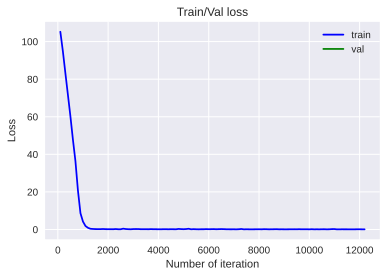

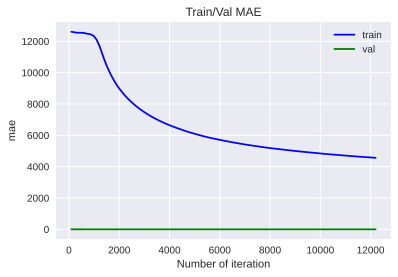

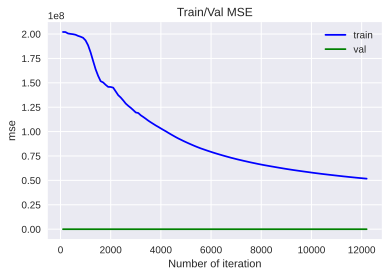

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

 **Prediction**

In [ ]:
_ = load_checkpoint('./cnn_w2v_best_checkpoint', model_w2v, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_w2v, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

Loading checkpoint './cnn_w2v_best_checkpoint'
Loaded checkpoint './cnn_w2v_best_checkpoint' from iteration 7799
MSE:  0.05705
MAE:  0.0891
LOSS:  0.22821


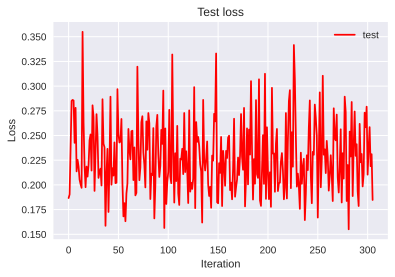

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Freesed embedding(word2vec) layer works well. Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.05705  
MAE:  0.0891  
LOSS:  0.22821  


### **Do not freeze**

**Training**

In [ ]:
model_w2v_no_freeze = SalaryPredictor(freezed=False).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_w2v_no_freeze.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_w2v_no_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_w2v_no_freeze_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 100.32771
VAL  RESULTS:
Iteration: 99  Mean square error: 25.37306  Mean absolute error: 2.51416 
Saving model and optimizer state at iteration 99 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 88.62249
VAL  RESULTS:
Iteration: 199  Mean square error: 22.51392  Mean absolute error: 2.36495 
Saving model and optimizer state at iteration 199 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 73.93312
VAL  RESULTS:
Iteration: 299  Mean square error: 19.40273  Mean absolute error: 2.19105 
Saving model and optimizer state at iteration 299 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 59.86103
VAL  RESULTS:
Iteration: 399  Mean square error: 15.31962  Mean absolute error: 1.92886 
Saving model and optimizer state at iteration 399 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 40.58221
VAL  RESULTS:
Iteration: 499  Mean square error: 10.24462  Mean absolute error: 1.56874 
Saving model and optimizer state at iteration 499 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.26853
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.78182  Mean absolute error: 0.39882 
Saving model and optimizer state at iteration 1299 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.17253
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.75944  Mean absolute error: 0.39549 
Saving model and optimizer state at iteration 1399 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.40623
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.60426  Mean absolute error: 0.34689 
Saving model and optimizer state at iteration 1499 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.13555
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.65102  Mean absolute error: 0.35966 
train_loss 0.43664
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.73575  Mean absolute error: 0.38756 
train_loss 0.45262
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.66077  Mean absolute error: 0.36364 
train_loss 0.85214
VAL  RESULTS:
Iteration: 1899  Mean square error: 0.75129  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.24312
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.72927  Mean absolute error: 0.39818 
train_loss 0.37437
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.68993  Mean absolute error: 0.38378 
train_loss 0.17424
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.76623  Mean absolute error: 0.41087 
train_loss 0.27261
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.73017  Mean absolute error: 0.39998 
train_loss 0.34567
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.91548  Mean absolute error: 0.44735 
train_loss 0.18499
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.96194  Mean absolute error: 0.46376 
train_loss 0.47102
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.90923  Mean absolute error: 0.44791 
train_loss 0.15192
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.95714  Mean absolute error: 0.46244 
train_loss 0.12219
VAL  RESULTS:
Iteration: 3299  Mean square error: 0.73428  Mean absolute error: 0.40211 
train_loss 0.13297
VAL  RESU

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18487
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.98854  Mean absolute error: 0.47178 
train_loss 0.14692
VAL  RESULTS:
Iteration: 3799  Mean square error: 1.05283  Mean absolute error: 0.48644 
train_loss 0.43642
VAL  RESULTS:
Iteration: 3899  Mean square error: 1.24423  Mean absolute error: 0.53241 
train_loss 0.17722
VAL  RESULTS:
Iteration: 3999  Mean square error: 1.15794  Mean absolute error: 0.51095 
train_loss 0.56823
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.02133  Mean absolute error: 0.47496 
train_loss 0.16773
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.9752  Mean absolute error: 0.4579 
train_loss 0.09003
VAL  RESULTS:
Iteration: 4299  Mean square error: 1.08921  Mean absolute error: 0.48983 
train_loss 0.10543
VAL  RESULTS:
Iteration: 4399  Mean square error: 1.16226  Mean absolute error: 0.50557 
train_loss 0.08597
VAL  RESULTS:
Iteration: 4499  Mean square error: 1.20838  Mean absolute error: 0.51912 
train_loss 0.10513
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18474
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.96606  Mean absolute error: 0.4599 
train_loss 0.37901
VAL  RESULTS:
Iteration: 4999  Mean square error: 1.20001  Mean absolute error: 0.51699 
train_loss 0.09752
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.05387  Mean absolute error: 0.48347 
train_loss 0.13368
VAL  RESULTS:
Iteration: 5199  Mean square error: 1.19361  Mean absolute error: 0.51506 
train_loss 0.32982
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.12378  Mean absolute error: 0.49875 
train_loss 0.07542
VAL  RESULTS:
Iteration: 5399  Mean square error: 1.05239  Mean absolute error: 0.48282 
train_loss 0.07051
VAL  RESULTS:
Iteration: 5499  Mean square error: 1.08766  Mean absolute error: 0.48914 
train_loss 0.29655
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.92837  Mean absolute error: 0.44762 
train_loss 0.13993
VAL  RESULTS:
Iteration: 5699  Mean square error: 1.24132  Mean absolute error: 0.52583 
train_loss 0.3034
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13857
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.01636  Mean absolute error: 0.47258 
train_loss 0.14583
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.10369  Mean absolute error: 0.4956 
train_loss 0.08455
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.02951  Mean absolute error: 0.47761 
train_loss 0.09294
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.9751  Mean absolute error: 0.46171 
train_loss 0.16274
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.10086  Mean absolute error: 0.4889 
train_loss 0.14369
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.06229  Mean absolute error: 0.48403 
train_loss 0.08975
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.12315  Mean absolute error: 0.499 
train_loss 0.07584
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.01872  Mean absolute error: 0.47519 
train_loss 0.11224
VAL  RESULTS:
Iteration: 6999  Mean square error: 1.23842  Mean absolute error: 0.52754 
train_loss 0.14434
VAL  RESULTS:


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09265
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.00262  Mean absolute error: 0.47389 
train_loss 0.05748
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.07413  Mean absolute error: 0.48931 
train_loss 0.2033
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.97353  Mean absolute error: 0.46432 
train_loss 0.11664
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.97262  Mean absolute error: 0.46456 
train_loss 0.08204
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.19259  Mean absolute error: 0.51661 
train_loss 0.21426
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.98925  Mean absolute error: 0.47084 
train_loss 0.08979
VAL  RESULTS:
Iteration: 7999  Mean square error: 1.04644  Mean absolute error: 0.48554 
train_loss 0.07776
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.98144  Mean absolute error: 0.46975 
train_loss 0.11998
VAL  RESULTS:
Iteration: 8199  Mean square error: 0.89928  Mean absolute error: 0.44775 
train_loss 0.08355
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09527
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.94993  Mean absolute error: 0.46355 
train_loss 0.13332
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.99201  Mean absolute error: 0.47131 
train_loss 0.0931
VAL  RESULTS:
Iteration: 8799  Mean square error: 1.02902  Mean absolute error: 0.48396 
train_loss 0.12175
VAL  RESULTS:
Iteration: 8899  Mean square error: 1.06161  Mean absolute error: 0.4914 
train_loss 0.09149
VAL  RESULTS:
Iteration: 8999  Mean square error: 1.09048  Mean absolute error: 0.49944 
train_loss 0.08572
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.97927  Mean absolute error: 0.47158 
train_loss 0.12166
VAL  RESULTS:
Iteration: 9199  Mean square error: 1.22986  Mean absolute error: 0.53253 
train_loss 0.07653
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.9344  Mean absolute error: 0.45583 
train_loss 0.08442
VAL  RESULTS:
Iteration: 9399  Mean square error: 1.0115  Mean absolute error: 0.47743 
train_loss 0.10397
VAL  RESULTS:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07328
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.82108  Mean absolute error: 0.43151 
train_loss 0.1137
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.92988  Mean absolute error: 0.45697 
train_loss 0.06962
VAL  RESULTS:
Iteration: 9999  Mean square error: 1.00685  Mean absolute error: 0.48087 
train_loss 0.14971
VAL  RESULTS:
Iteration: 10099  Mean square error: 1.04571  Mean absolute error: 0.48921 
train_loss 0.0916
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.95897  Mean absolute error: 0.46836 
train_loss 0.11515
VAL  RESULTS:
Iteration: 10299  Mean square error: 1.04818  Mean absolute error: 0.48851 
train_loss 0.08478
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.8526  Mean absolute error: 0.44032 
train_loss 0.10475
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.86002  Mean absolute error: 0.4416 
train_loss 0.12611
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.93418  Mean absolute error: 0.46186 
train_loss 0.07616
VAL  RE

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06957
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.84666  Mean absolute error: 0.43786 
train_loss 0.11286
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.69977  Mean absolute error: 0.39693 
train_loss 0.0607
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.75216  Mean absolute error: 0.41114 
train_loss 0.08356
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.76546  Mean absolute error: 0.41682 
train_loss 0.06742
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.74113  Mean absolute error: 0.40839 
train_loss 0.09256
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.83493  Mean absolute error: 0.43646 
train_loss 0.11203
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.79681  Mean absolute error: 0.42515 
train_loss 0.08247
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.67944  Mean absolute error: 0.39096 
train_loss 0.05549
VAL  RESULTS:
Iteration: 11899  Mean square error: 0.77714  Mean absolute error: 0.41923 
train_loss 0.05983
V

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_no_freeze_regr' 

lr=1e-3
save_checkpoint(model_w2v_no_freeze, optimizer, lr, EPOCHS, model_path)

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_no_freeze_regr


**Visualization**

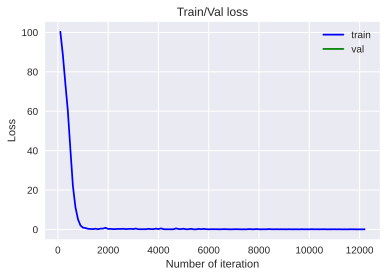

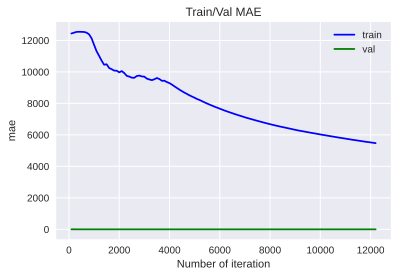

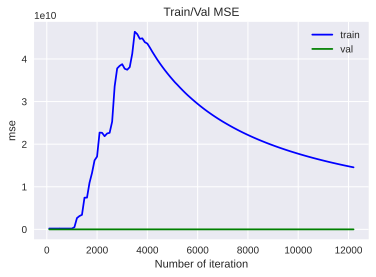

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**


In [ ]:
_ = load_checkpoint('./cnn_w2v_no_freeze_best_checkpoint', model_w2v_no_freeze, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_w2v_no_freeze, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5)) 

Loading checkpoint './cnn_w2v_no_freeze_best_checkpoint'
Loaded checkpoint './cnn_w2v_no_freeze_best_checkpoint' from iteration 2199
MSE:  0.58204
MAE:  0.34345
LOSS:  2.32817


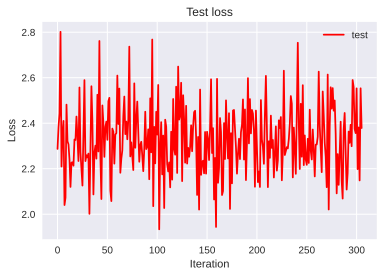

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Metrics jump a lot in the initial training of the model, however, at about the 4th epoch, metrics are regularized and decrease.
Not freezed embedding(word2vec) layer works not so well. The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.05705  
MAE:  0.0891  
LOSS:  0.22821  


## **GloVe**

In [ ]:
corpus_glove = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
len(corpus_glove.vocab)

1193514

In [ ]:
weights_matrix = set_weights(corpus_glove, 200)

**Model**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(200, hid_size*2, kernel_size=3),
            nn.Tanh(),
            MaxTimePooling(),
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(200, hid_size*2, kernel_size=3),
            nn.ELU(),
            MaxTimePooling(),
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(200, hid_size, kernel_size=5),
            nn.ELU(),
            MaxTimePooling(),
        )

        self.joke_encoder_4 = nn.Sequential(
            nn.Conv1d(200, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            MaxTimePooling(),
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features_4 = self.joke_encoder_4(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3, joke_features_4], dim=1)

        return self.final_predictor(joke_features).squeeze()

### **Freeze**

**Training**

In [ ]:
# 37

model_tap = JokeRankPredictor(hid_size=128).to(DEVICE)
learning_rate = 0.008 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)


Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.4413572549819946  Accuracy: 33.25965881347656 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5395219326019287  Accuracy: 34.90040969848633 %
Saving model and optimizer state at iteration 199 to ./model_tap_best_checkpoint_v1
Iteration: 299  Loss: 1.4842764139175415  Accuracy: 33.595088958740234 %
Iteration: 399  Loss: 1.509546160697937  Accuracy: 33.53008270263672 %
Iteration: 499  Loss: 1.5106967687606812  Accuracy: 35.25404357910156 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.5223149061203003  Accuracy: 33.810909271240234 %
Iteration: 699  Loss: 1.5182223320007324  Accuracy: 35.28004455566406 %
Saving model and optimizer state at iteration 699 to ./model_tap_best_checkpoint_v1
Iteration: 799  Loss: 1.4527502059936523  Accuracy: 35.19683837890625 %
Iteration: 899  Loss: 1.5435558557510376  Accuracy: 34.421966552734375 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4370671510696411  Accuracy: 28.925060272216797 %
Iteration: 1099  Loss: 1.5415416955947876  Accuracy: 35.91970443725586 %
Saving model and optimizer state at iteration 1099 to ./model_tap_best_checkpoint_v1
Iteration: 1199  Loss: 1.5364060401916504  Accuracy: 36.14592361450195 %
Saving model and optimizer state at iteration 1199 to ./model_tap_best_checkpoint_v1
Iteration: 1299  Loss: 1.4734599590301514  Accuracy: 35.21503829956055 %
Iteration: 1399  Loss: 1.4760464429855347  Accuracy: 34.804203033447266 %
Iteration: 1499  Loss: 1.5580410957336426  Accuracy: 35.03822326660156 %
Iteration: 1599  Loss: 1.4858390092849731  Accuracy: 36.216129302978516 %
Saving model and optimizer state at iteration 1599 to ./model_tap_best_checkpoint_v1
Iteration: 1699  Loss: 1.5024334192276  Accuracy: 34.69758987426758 %
Iteration: 1799  Loss: 1.5377751588821411  Accuracy: 36.252532958984375 %
Saving model and optimizer state at iteration 1799 to ./model_tap_best_checkpoint_v1
Ite

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4639179706573486  Accuracy: 35.26704406738281 %
Iteration: 2099  Loss: 1.4764719009399414  Accuracy: 35.68568420410156 %
Iteration: 2199  Loss: 1.460702657699585  Accuracy: 36.5489616394043 %
Iteration: 2299  Loss: 1.4898604154586792  Accuracy: 36.53335952758789 %
Iteration: 2399  Loss: 1.5581811666488647  Accuracy: 35.14223098754883 %
Iteration: 2499  Loss: 1.5120028257369995  Accuracy: 34.11513900756836 %
Iteration: 2599  Loss: 1.5291823148727417  Accuracy: 33.649696350097656 %
Iteration: 2699  Loss: 1.5195258855819702  Accuracy: 35.68568420410156 %
Iteration: 2799  Loss: 1.5281418561935425  Accuracy: 35.529666900634766 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4667794704437256  Accuracy: 35.300846099853516 %
Iteration: 2999  Loss: 1.4749411344528198  Accuracy: 33.24925994873047 %
Iteration: 3099  Loss: 1.4260622262954712  Accuracy: 35.19943618774414 %
Iteration: 3199  Loss: 1.4755964279174805  Accuracy: 34.78860092163086 %
Iteration: 3299  Loss: 1.4643961191177368  Accuracy: 35.05642318725586 %
Iteration: 3399  Loss: 1.4763224124908447  Accuracy: 35.225440979003906 %
Iteration: 3499  Loss: 1.5397080183029175  Accuracy: 36.598365783691406 %
Iteration: 3599  Loss: 1.5189449787139893  Accuracy: 36.33574295043945 %
Iteration: 3699  Loss: 1.4660072326660156  Accuracy: 36.54636001586914 %
Iteration: 3799  Loss: 1.5148169994354248  Accuracy: 36.455352783203125 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.4994817972183228  Accuracy: 33.95912170410156 %
Iteration: 3999  Loss: 1.3894860744476318  Accuracy: 36.694576263427734 %
Saving model and optimizer state at iteration 3999 to ./model_tap_best_checkpoint_v1
Iteration: 4099  Loss: 1.4630835056304932  Accuracy: 36.010711669921875 %
Iteration: 4199  Loss: 1.5126023292541504  Accuracy: 36.63737106323242 %
Iteration: 4299  Loss: 1.4255644083023071  Accuracy: 36.14852523803711 %
Iteration: 4399  Loss: 1.468687891960144  Accuracy: 34.97061538696289 %
Iteration: 4499  Loss: 1.4538377523422241  Accuracy: 36.45795440673828 %
Iteration: 4599  Loss: 1.478124976158142  Accuracy: 36.19272994995117 %
Iteration: 4699  Loss: 1.5541685819625854  Accuracy: 36.27333450317383 %
Iteration: 4799  Loss: 1.5272166728973389  Accuracy: 35.30864715576172 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4410128593444824  Accuracy: 33.8291130065918 %
Iteration: 4999  Loss: 1.483186960220337  Accuracy: 35.24104309082031 %
Iteration: 5099  Loss: 1.4584699869155884  Accuracy: 33.74070358276367 %
Iteration: 5199  Loss: 1.4548429250717163  Accuracy: 35.844295501708984 %
Iteration: 5299  Loss: 1.4484105110168457  Accuracy: 32.91642761230469 %
Iteration: 5399  Loss: 1.463935136795044  Accuracy: 35.33205032348633 %
Iteration: 5499  Loss: 1.4653526544570923  Accuracy: 36.164127349853516 %
Iteration: 5599  Loss: 1.5285494327545166  Accuracy: 34.601383209228516 %
Iteration: 5699  Loss: 1.5146524906158447  Accuracy: 36.04191589355469 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.360681414604187  Accuracy: 35.75328826904297 %


KeyboardInterrupt: ignored

**Save model**

In [ ]:
# model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_regr' 

# lr=1e-3
# save_checkpoint(model_glv, optimizer, lr, EPOCHS, model_path)

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_glv_best_checkpoint', model_glv, optimizer)

# mse, mae, test_loss, loss_arr = make_prediction(model_glv, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5)) 

**Conclusion** 

Freesed embedding(glove) layer works well. Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***:   
MSE:  0.06061  
MAE:  0.09801  
LOSS:  0.24246  


### **Do not freeze**

**Training**

In [ ]:
# 37

model_tap = JokeRankPredictor(freezed=False, hid_size=128).to(DEVICE)
learning_rate = 0.009 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)


Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5153779983520508  Accuracy: 34.5545768737793 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5420949459075928  Accuracy: 34.052730560302734 %
Iteration: 299  Loss: 1.470536708831787  Accuracy: 35.51926803588867 %
Saving model and optimizer state at iteration 299 to ./model_tap_best_checkpoint_v1
Iteration: 399  Loss: 1.5388585329055786  Accuracy: 32.354774475097656 %
Iteration: 499  Loss: 1.478776454925537  Accuracy: 34.536376953125 %
Iteration: 599  Loss: 1.5101429224014282  Accuracy: 32.531593322753906 %
Iteration: 699  Loss: 1.5251133441925049  Accuracy: 31.5226993560791 %
Iteration: 799  Loss: 1.5327380895614624  Accuracy: 33.644493103027344 %
Iteration: 899  Loss: 1.5511462688446045  Accuracy: 37.102813720703125 %
Saving model and optimizer state at iteration 899 to ./model_tap_best_checkpoint_v1
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.4058765172958374  Accuracy: 35.46206283569336 %
Iteration: 1099  Loss: 1.4887462854385376  Accuracy: 33.062042236328125 %
Iteration: 1199  Loss: 1.387110710144043  Accuracy: 36.17452621459961 %
Iteration: 1299  Loss: 1.4867873191833496  Accuracy: 36.38774871826172 %
Iteration: 1399  Loss: 1.505021572113037  Accuracy: 36.743980407714844 %
Iteration: 1499  Loss: 1.5020240545272827  Accuracy: 36.923397064208984 %
Iteration: 1599  Loss: 1.5020251274108887  Accuracy: 36.43715286254883 %
Iteration: 1699  Loss: 1.479997158050537  Accuracy: 37.17301940917969 %
Saving model and optimizer state at iteration 1699 to ./model_tap_best_checkpoint_v1
Iteration: 1799  Loss: 1.4313693046569824  Accuracy: 35.97951126098633 %
Iteration: 1899  Loss: 1.4779506921768188  Accuracy: 36.840187072753906 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.3889961242675781  Accuracy: 35.87810134887695 %
Iteration: 2099  Loss: 1.4465751647949219  Accuracy: 31.275676727294922 %
Iteration: 2199  Loss: 1.4579744338989258  Accuracy: 35.88330078125 %
Iteration: 2299  Loss: 1.4731354713439941  Accuracy: 36.00551223754883 %


KeyboardInterrupt: ignored

In [ ]:
model_tap = JokeRankPredictor(freezed=False, hid_size=32).to(DEVICE)
learning_rate = 0.008 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)


Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5316298007965088  Accuracy: 34.9862174987793 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5297400951385498  Accuracy: 33.977325439453125 %
Iteration: 299  Loss: 1.5130212306976318  Accuracy: 36.08612060546875 %
Saving model and optimizer state at iteration 299 to ./model_tap_best_checkpoint_v1
Iteration: 399  Loss: 1.5257782936096191  Accuracy: 34.49217224121094 %
Iteration: 499  Loss: 1.5085781812667847  Accuracy: 36.634769439697266 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.5005642175674438  Accuracy: 30.77383041381836 %
Iteration: 699  Loss: 1.519612193107605  Accuracy: 36.38514709472656 %
Iteration: 799  Loss: 1.5069990158081055  Accuracy: 37.188621520996094 %
Saving model and optimizer state at iteration 799 to ./model_tap_best_checkpoint_v1
Iteration: 899  Loss: 1.5325380563735962  Accuracy: 36.92079544067383 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.483270525932312  Accuracy: 36.850589752197266 %
Iteration: 1099  Loss: 1.5291131734848022  Accuracy: 36.18492889404297 %
Iteration: 1199  Loss: 1.445452332496643  Accuracy: 36.91819381713867 %
Iteration: 1299  Loss: 1.4555439949035645  Accuracy: 36.31753921508789 %
Iteration: 1399  Loss: 1.5168763399124146  Accuracy: 36.671173095703125 %
Iteration: 1499  Loss: 1.5189893245697021  Accuracy: 35.51146697998047 %
Iteration: 1599  Loss: 1.5262234210968018  Accuracy: 37.08721160888672 %
Iteration: 1699  Loss: 1.4294495582580566  Accuracy: 36.28373718261719 %
Iteration: 1799  Loss: 1.4572886228561401  Accuracy: 36.77518081665039 %
Iteration: 1899  Loss: 1.4415568113327026  Accuracy: 36.69197463989258 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.405163049697876  Accuracy: 36.29413986206055 %
Iteration: 2099  Loss: 1.3786592483520508  Accuracy: 35.60507583618164 %
Iteration: 2199  Loss: 1.4336506128311157  Accuracy: 35.048622131347656 %
Iteration: 2299  Loss: 1.423042893409729  Accuracy: 35.49586486816406 %
Iteration: 2399  Loss: 1.4726250171661377  Accuracy: 36.429351806640625 %


KeyboardInterrupt: ignored

In [ ]:
model_tap = JokeRankPredictor(freezed=False, hid_size=8).to(DEVICE)
learning_rate = 0.009 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)


Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.4961462020874023  Accuracy: 33.353267669677734 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5838451385498047  Accuracy: 33.55348587036133 %
Saving model and optimizer state at iteration 199 to ./model_tap_best_checkpoint_v1
Iteration: 299  Loss: 1.5453429222106934  Accuracy: 35.67788314819336 %
Saving model and optimizer state at iteration 299 to ./model_tap_best_checkpoint_v1
Iteration: 399  Loss: 1.5112875699996948  Accuracy: 35.6492805480957 %
Iteration: 499  Loss: 1.5849488973617554  Accuracy: 35.89630126953125 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.4990960359573364  Accuracy: 36.49435806274414 %
Saving model and optimizer state at iteration 599 to ./model_tap_best_checkpoint_v1
Iteration: 699  Loss: 1.4833290576934814  Accuracy: 36.43715286254883 %
Iteration: 799  Loss: 1.514968991279602  Accuracy: 36.44755172729492 %
Iterati

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5260690450668335  Accuracy: 36.67897415161133 %
Iteration: 1099  Loss: 1.5084257125854492  Accuracy: 35.95870590209961 %
Iteration: 1199  Loss: 1.4286764860153198  Accuracy: 35.742889404296875 %
Iteration: 1299  Loss: 1.537528395652771  Accuracy: 36.16152572631836 %
Iteration: 1399  Loss: 1.5287880897521973  Accuracy: 36.572364807128906 %
Iteration: 1499  Loss: 1.481433391571045  Accuracy: 37.030006408691406 %
Saving model and optimizer state at iteration 1499 to ./model_tap_best_checkpoint_v1
Iteration: 1599  Loss: 1.4786205291748047  Accuracy: 36.10432052612305 %
Iteration: 1699  Loss: 1.4697377681732178  Accuracy: 36.24213409423828 %
Iteration: 1799  Loss: 1.4949616193771362  Accuracy: 37.05080795288086 %
Saving model and optimizer state at iteration 1799 to ./model_tap_best_checkpoint_v1
Iteration: 1899  Loss: 1.5242658853530884  Accuracy: 36.541160583496094 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.37277352809906  Accuracy: 35.40745544433594 %
Iteration: 2099  Loss: 1.469903826713562  Accuracy: 35.50886535644531 %
Iteration: 2199  Loss: 1.4183319807052612  Accuracy: 36.694576263427734 %
Iteration: 2299  Loss: 1.4321998357772827  Accuracy: 36.14852523803711 %
Iteration: 2399  Loss: 1.4456411600112915  Accuracy: 36.52555847167969 %
Iteration: 2499  Loss: 1.4645767211914062  Accuracy: 36.491756439208984 %
Iteration: 2599  Loss: 1.4286085367202759  Accuracy: 35.17863464355469 %
Iteration: 2699  Loss: 1.4630218744277954  Accuracy: 36.262935638427734 %
Iteration: 2799  Loss: 1.4275038242340088  Accuracy: 36.416351318359375 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.396294355392456  Accuracy: 36.22393035888672 %
Iteration: 2999  Loss: 1.414157509803772  Accuracy: 35.39445495605469 %


KeyboardInterrupt: ignored

**Save model**

In [ ]:
# model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_no_freeze_regr' 

# lr=1e-3
# save_checkpoint(model_glv_no_freeze, optimizer, lr, EPOCHS, model_path)

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
        #  mae_train_loss_array, mae_val_loss_array)

**Prediction**


In [ ]:
# _ = load_checkpoint('./cnn_glv_no_freeze_best_checkpoint', model_glv_no_freeze, optimizer)

# mse, mae, test_loss, loss_arr = make_prediction(model_glv_no_freeze, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5)) 

**Conclusion**

* Metrics jump a lot in the initial training of the model, especially MSE, but at about the 4th epoch, metrics are regularized and reduced. You can see that the metrics are also higher than expected.
* Not freezed embedding(word2vec) layer works not so well. The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.39391  
MAE:  0.28766  
LOSS:  1.57564  


## **General conclusion №3**


If we compare embeddings, initialized randomly and pre-trained embeddings with frozen weights, then they worked out for this task in almost the same way.
It is worth noting that Word2Vec with frozen weights coped with the task best of all. The Glove embedding was also tested, but it coped with the task slightly worse. When we unfreeze weights and try to stretch them for our task, the model behaves erratically, we need longer training and optimization.


# **🚩 4. Замена сверточных слоев на рекуррентные**

* Замена сверточных слоев рекуррентными LSTM/GRU.
* Эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью


### **1) GRU**

In [ ]:
class GRUPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_gru = nn.GRU(hid_size,hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.ELU()
        

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['joke'])
        output, hidden_title = self.title_gru(title_embeddings)     
        hidden_title = torch.cat([hidden_title[i,:, :] for i in range(hidden_title.shape[0])], dim=1)
        out_title = self.dr1(hidden_title)
        out_title = self.af1(out_title)

        return self.final_predictor(out_title).squeeze()

**Training**

In [ ]:
model_gru = GRUPredictor(hid_size=64).to(DEVICE)
learning_rate = 0.007 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_gru, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_gru_best_checkpoint_v1",
          device=DEVICE)


Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.555938482284546  Accuracy: 32.476985931396484 %
Saving model and optimizer state at iteration 99 to ./model_gru_best_checkpoint_v1
Iteration: 199  Loss: 1.5785112380981445  Accuracy: 32.95283126831055 %
Saving model and optimizer state at iteration 199 to ./model_gru_best_checkpoint_v1
Iteration: 299  Loss: 1.5843307971954346  Accuracy: 33.420875549316406 %
Saving model and optimizer state at iteration 299 to ./model_gru_best_checkpoint_v1
Iteration: 399  Loss: 1.5155916213989258  Accuracy: 33.55088424682617 %
Saving model and optimizer state at iteration 399 to ./model_gru_best_checkpoint_v1
Iteration: 499  Loss: 1.5263512134552002  Accuracy: 34.408966064453125 %
Saving model and optimizer state at iteration 499 to ./model_gru_best_checkpoint_v1
Iteration: 599  Loss: 1.5584700107574463  Accuracy: 33.173851013183594 %
Iteration: 699  Loss: 1.578166127204895  Accuracy: 34.133338928222656 %
Iteration: 799  Loss: 1.5597437620162964  Accuracy: 34.27635192871094 %
Ite

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5401540994644165  Accuracy: 34.72879409790039 %
Saving model and optimizer state at iteration 999 to ./model_gru_best_checkpoint_v1
Iteration: 1099  Loss: 1.5651546716690063  Accuracy: 34.58058166503906 %
Iteration: 1199  Loss: 1.4937827587127686  Accuracy: 34.939414978027344 %
Saving model and optimizer state at iteration 1199 to ./model_gru_best_checkpoint_v1
Iteration: 1299  Loss: 1.5499681234359741  Accuracy: 35.00442123413086 %
Saving model and optimizer state at iteration 1299 to ./model_gru_best_checkpoint_v1
Iteration: 1399  Loss: 1.5313059091567993  Accuracy: 34.9940185546875 %
Iteration: 1499  Loss: 1.562077283859253  Accuracy: 34.98101806640625 %
Iteration: 1599  Loss: 1.5645451545715332  Accuracy: 35.183837890625 %
Saving model and optimizer state at iteration 1599 to ./model_gru_best_checkpoint_v1
Iteration: 1699  Loss: 1.5062801837921143  Accuracy: 35.40225601196289 %
Saving model and optimizer state at iteration 1699 to ./model_gru_best_checkpoint

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5166898965835571  Accuracy: 34.471370697021484 %
Iteration: 2099  Loss: 1.5547208786010742  Accuracy: 34.93161392211914 %
Iteration: 2199  Loss: 1.5064246654510498  Accuracy: 34.674190521240234 %
Iteration: 2299  Loss: 1.4855912923812866  Accuracy: 35.21503829956055 %
Iteration: 2399  Loss: 1.5214322805404663  Accuracy: 34.34395980834961 %
Iteration: 2499  Loss: 1.582961082458496  Accuracy: 34.36736297607422 %
Iteration: 2599  Loss: 1.505813717842102  Accuracy: 35.2176399230957 %
Iteration: 2699  Loss: 1.4908092021942139  Accuracy: 35.42045974731445 %
Iteration: 2799  Loss: 1.5396671295166016  Accuracy: 34.98881912231445 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5319198369979858  Accuracy: 35.29044723510742 %
Iteration: 2999  Loss: 1.519670009613037  Accuracy: 34.92381286621094 %
Iteration: 3099  Loss: 1.4790382385253906  Accuracy: 35.09022903442383 %
Iteration: 3199  Loss: 1.5026378631591797  Accuracy: 35.01742172241211 %
Iteration: 3299  Loss: 1.5223541259765625  Accuracy: 34.91341018676758 %
Iteration: 3399  Loss: 1.500199794769287  Accuracy: 35.20463943481445 %
Iteration: 3499  Loss: 1.4635742902755737  Accuracy: 35.12403106689453 %
Iteration: 3599  Loss: 1.5279496908187866  Accuracy: 34.939414978027344 %
Iteration: 3699  Loss: 1.4932600259780884  Accuracy: 35.170833587646484 %
Iteration: 3799  Loss: 1.512912631034851  Accuracy: 35.13703155517578 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.500601053237915  Accuracy: 35.069427490234375 %
Iteration: 3999  Loss: 1.48615300655365  Accuracy: 34.72879409790039 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./gru_best_checkpoint', model_gru, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_gru, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

The loss is not so good this time. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.
* *** Average cross-validation scores ***:  

MSE:  0.667  
MAE:  0.40203  
LOSS:  2.668  


### **2) LSTM**

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.ReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        # title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_embeddings = self.embedder(batch['joke'])
        output, (h_n_title, c_n_title) = self.title_lstm(title_embeddings)     
        h_n_title = torch.squeeze(h_n_title, 0)
        out_title = self.dr1(h_n_title)
        out_title = self.af1(out_title)
        
        return self.final_predictor(out_title).squeeze()

**Training**

In [ ]:
model_lstm = LSTMPredictor( hid_size=128).to(DEVICE)
learning_rate = 0.001 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_lstm.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_lstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_lstm_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.562551736831665  Accuracy: 31.579904556274414 %
Saving model and optimizer state at iteration 99 to ./model_lstm_best_checkpoint_v1
Iteration: 199  Loss: 1.583104133605957  Accuracy: 31.59550666809082 %
Saving model and optimizer state at iteration 199 to ./model_lstm_best_checkpoint_v1
Iteration: 299  Loss: 1.563063144683838  Accuracy: 31.600706100463867 %
Saving model and optimizer state at iteration 299 to ./model_lstm_best_checkpoint_v1
Iteration: 399  Loss: 1.5903077125549316  Accuracy: 31.605907440185547 %
Saving model and optimizer state at iteration 399 to ./model_lstm_best_checkpoint_v1
Iteration: 499  Loss: 1.5112453699111938  Accuracy: 31.600706100463867 %
Iteration: 599  Loss: 1.5421475172042847  Accuracy: 21.368764877319336 %
Iteration: 699  Loss: 1.573883056640625  Accuracy: 31.569503784179688 %
Iteration: 799  Loss: 1.5828619003295898  Accuracy: 31.63970947265625 %
Saving model and optimizer state at iteration 799 to ./model_lstm_best_checkpoint_v1

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.6020939350128174  Accuracy: 31.551301956176758 %
Iteration: 1099  Loss: 1.5820703506469727  Accuracy: 31.592905044555664 %
Iteration: 1199  Loss: 1.56215238571167  Accuracy: 31.592905044555664 %
Iteration: 1299  Loss: 1.5674570798873901  Accuracy: 31.587705612182617 %
Iteration: 1399  Loss: 1.560694694519043  Accuracy: 31.670913696289062 %
Saving model and optimizer state at iteration 1399 to ./model_lstm_best_checkpoint_v1
Iteration: 1499  Loss: 1.5649081468582153  Accuracy: 29.881948471069336 %
Iteration: 1599  Loss: 1.5122114419937134  Accuracy: 30.890840530395508 %
Iteration: 1699  Loss: 1.5904209613800049  Accuracy: 33.75370407104492 %
Saving model and optimizer state at iteration 1699 to ./model_lstm_best_checkpoint_v1
Iteration: 1799  Loss: 1.542259931564331  Accuracy: 33.40787124633789 %
Iteration: 1899  Loss: 1.5561085939407349  Accuracy: 27.162097930908203 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5384597778320312  Accuracy: 28.732643127441406 %
Iteration: 2099  Loss: 1.5619510412216187  Accuracy: 29.998958587646484 %
Iteration: 2199  Loss: 1.5248254537582397  Accuracy: 34.20354461669922 %
Saving model and optimizer state at iteration 2199 to ./model_lstm_best_checkpoint_v1
Iteration: 2299  Loss: 1.574177622795105  Accuracy: 31.20547103881836 %
Iteration: 2399  Loss: 1.586275577545166  Accuracy: 29.237089157104492 %
Iteration: 2499  Loss: 1.5487841367721558  Accuracy: 32.52119064331055 %
Iteration: 2599  Loss: 1.5676190853118896  Accuracy: 29.46331024169922 %
Iteration: 2699  Loss: 1.6214253902435303  Accuracy: 33.8551139831543 %
Iteration: 2799  Loss: 1.5405957698822021  Accuracy: 32.248165130615234 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5349587202072144  Accuracy: 31.733318328857422 %
Iteration: 2999  Loss: 1.5529191493988037  Accuracy: 31.587705612182617 %
Iteration: 3099  Loss: 1.5897468328475952  Accuracy: 31.449892044067383 %
Iteration: 3199  Loss: 1.5360714197158813  Accuracy: 32.583595275878906 %
Iteration: 3299  Loss: 1.5327460765838623  Accuracy: 31.457693099975586 %
Iteration: 3399  Loss: 1.5579028129577637  Accuracy: 33.569087982177734 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./lstm_best_checkpoint', model_lstm, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_lstm, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

This time  loss is lower but still is not low enough. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.
 
* *** Average cross-validation scores ***:  

MSE:  0.45689  
MAE:  0.32986  
LOSS:  1.82756  

### **3) BiLSTM**

In [ ]:
class BiLSTMPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_lstm = nn.LSTM(hid_size,
                                  hid_size,
                                  num_layers=2, 
                                  bidirectional=True,
                                  batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.LeakyReLU()

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['joke'])
        output, (h_n_title, c_n_title) = self.title_lstm(title_embeddings)     
        h_n_title = torch.cat([h_n_title[i,:, :] for i in range(h_n_title.shape[0])], dim=1)
        out_title = self.dr1(h_n_title)
        out_title = self.af1(out_title)

        return self.final_predictor(out_title).squeeze()

**Training**

In [ ]:
model_bilstm = BiLSTMPredictor(hid_size=8).to(DEVICE)
learning_rate = 0.009 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_bilstm.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_bilstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_bilstm_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.579403042793274  Accuracy: 31.481096267700195 %
Saving model and optimizer state at iteration 99 to ./model_bilstm_best_checkpoint_v1
Iteration: 199  Loss: 1.5483962297439575  Accuracy: 32.7916145324707 %
Saving model and optimizer state at iteration 199 to ./model_bilstm_best_checkpoint_v1
Iteration: 299  Loss: 1.5240315198898315  Accuracy: 32.75261306762695 %
Iteration: 399  Loss: 1.5576419830322266  Accuracy: 34.265953063964844 %
Saving model and optimizer state at iteration 399 to ./model_bilstm_best_checkpoint_v1
Iteration: 499  Loss: 1.5733181238174438  Accuracy: 34.37776184082031 %
Saving model and optimizer state at iteration 499 to ./model_bilstm_best_checkpoint_v1
Iteration: 599  Loss: 1.548311710357666  Accuracy: 34.34395980834961 %
Iteration: 699  Loss: 1.5918251276016235  Accuracy: 34.29715347290039 %
Iteration: 799  Loss: 1.5450398921966553  Accuracy: 34.445369720458984 %
Saving model and optimizer state at iteration 799 to ./model_bilstm_best_check

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.519146203994751  Accuracy: 33.85771560668945 %
Iteration: 1099  Loss: 1.5667911767959595  Accuracy: 35.009620666503906 %
Saving model and optimizer state at iteration 1099 to ./model_bilstm_best_checkpoint_v1
Iteration: 1199  Loss: 1.5652116537094116  Accuracy: 34.7183952331543 %
Iteration: 1299  Loss: 1.5338127613067627  Accuracy: 34.57537841796875 %
Iteration: 1399  Loss: 1.5124300718307495  Accuracy: 34.79640197753906 %
Iteration: 1499  Loss: 1.5169494152069092  Accuracy: 34.905609130859375 %
Iteration: 1599  Loss: 1.519566297531128  Accuracy: 35.334651947021484 %
Saving model and optimizer state at iteration 1599 to ./model_bilstm_best_checkpoint_v1
Iteration: 1699  Loss: 1.473813772201538  Accuracy: 35.78709030151367 %
Saving model and optimizer state at iteration 1699 to ./model_bilstm_best_checkpoint_v1
Iteration: 1799  Loss: 1.5097358226776123  Accuracy: 35.12923049926758 %
Iteration: 1899  Loss: 1.5768992900848389  Accuracy: 35.25404357910156 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5311243534088135  Accuracy: 35.54526901245117 %
Iteration: 2099  Loss: 1.5223945379257202  Accuracy: 35.324249267578125 %
Iteration: 2199  Loss: 1.498482584953308  Accuracy: 35.54526901245117 %
Iteration: 2299  Loss: 1.4774284362792969  Accuracy: 35.2280387878418 %
Iteration: 2399  Loss: 1.5091572999954224  Accuracy: 35.53746795654297 %
Iteration: 2499  Loss: 1.5019904375076294  Accuracy: 35.974308013916016 %
Saving model and optimizer state at iteration 2499 to ./model_bilstm_best_checkpoint_v1
Iteration: 2599  Loss: 1.5237728357315063  Accuracy: 35.08762741088867 %
Iteration: 2699  Loss: 1.5044842958450317  Accuracy: 35.935306549072266 %
Iteration: 2799  Loss: 1.5297436714172363  Accuracy: 35.07982635498047 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.467252492904663  Accuracy: 36.06271743774414 %
Saving model and optimizer state at iteration 2899 to ./model_bilstm_best_checkpoint_v1
Iteration: 2999  Loss: 1.5285773277282715  Accuracy: 35.4178581237793 %
Iteration: 3099  Loss: 1.5098358392715454  Accuracy: 34.45317077636719 %
Iteration: 3199  Loss: 1.5235956907272339  Accuracy: 35.30864715576172 %
Iteration: 3299  Loss: 1.5202546119689941  Accuracy: 35.57387161254883 %
Iteration: 3399  Loss: 1.5172255039215088  Accuracy: 36.01331329345703 %
Iteration: 3499  Loss: 1.5300571918487549  Accuracy: 35.66228103637695 %
Iteration: 3599  Loss: 1.5085492134094238  Accuracy: 35.974308013916016 %
Iteration: 3699  Loss: 1.488966941833496  Accuracy: 35.480262756347656 %
Iteration: 3799  Loss: 1.481366753578186  Accuracy: 35.298248291015625 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.522042155265808  Accuracy: 34.905609130859375 %
Iteration: 3999  Loss: 1.4671430587768555  Accuracy: 35.441261291503906 %
Iteration: 4099  Loss: 1.4424376487731934  Accuracy: 35.15003204345703 %
Iteration: 4199  Loss: 1.494166374206543  Accuracy: 34.320556640625 %
Iteration: 4299  Loss: 1.483886480331421  Accuracy: 34.762596130371094 %
Iteration: 4399  Loss: 1.5112751722335815  Accuracy: 34.86400604248047 %
Iteration: 4499  Loss: 1.5238739252090454  Accuracy: 35.24884033203125 %
Iteration: 4599  Loss: 1.4704170227050781  Accuracy: 34.94721603393555 %
Iteration: 4699  Loss: 1.4865717887878418  Accuracy: 35.32685089111328 %
Iteration: 4799  Loss: 1.4758023023605347  Accuracy: 35.480262756347656 %
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4933280944824219  Accuracy: 34.5025749206543 %
Iteration: 4999  Loss: 1.464218258857727  Accuracy: 34.806800842285156 %
Iteration: 5099  Loss: 1.5258762836456299  Accuracy: 35.183837890625 %
Iteration: 5199  Loss: 1.498608946800232  Accuracy: 34.49997329711914 %
Iteration: 5299  Loss: 1.5387961864471436  Accuracy: 34.627384185791016 %
Iteration: 5399  Loss: 1.4234254360198975  Accuracy: 34.30755615234375 %


KeyboardInterrupt: ignored

**Visualization**


In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./bilstm_best_checkpoint', model_bilstm, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_bilstm, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**  

This model has the highest loss. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.

* *** Average cross-validation scores ***: 

MSE:  0.81589  
MAE:  0.44536  
LOSS:  3.26357  


### **4)Поиск удачного микса рекуррентных и сверточных слоев.**

**V1**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_conv1 = nn.Conv1d(hid_size, hid_size*2, kernel_size=3)
        self.af11 = nn.ReLU()
        self.title_lstm = nn.LSTM(hid_size*2, hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af12 = nn.ReLU()
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        out1 = self.title_conv1(title_embeddings)
        out1 = self.af11(out1).permute(0, 2, 1)
        output, (h_n_title, c_n_title) = self.title_lstm(out1)     
        h_n_title = torch.squeeze(h_n_title, 0)
        out_title = self.dr1(h_n_title)
        out_title = self.af12(out_title)
        
        return self.final_predictor(out_title).squeeze()

**Training**

In [ ]:
model_hybrid = JokeRankPredictor(hid_size=64).to(DEVICE)
learning_rate = 0.1 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hybrid.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_hybrid, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_hybrid_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5688796043395996  Accuracy: 31.473295211791992 %
Saving model and optimizer state at iteration 99 to ./model_hybrid_best_checkpoint_v1
Iteration: 199  Loss: 1.6235816478729248  Accuracy: 31.473295211791992 %
Iteration: 299  Loss: 1.639207124710083  Accuracy: 31.473295211791992 %
Iteration: 399  Loss: 1.545457124710083  Accuracy: 31.473295211791992 %
Iteration: 499  Loss: 1.6313945055007935  Accuracy: 31.473295211791992 %
Iteration: 599  Loss: 1.537644624710083  Accuracy: 31.473295211791992 %
Iteration: 699  Loss: 1.553269624710083  Accuracy: 31.473295211791992 %
Iteration: 799  Loss: 1.568894624710083  Accuracy: 31.473295211791992 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./hybrid_best_checkpoint', model_hybrid, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_hybrid, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

* Metrics jump a lot at the beginning of model training, however, at about the 4th epoch, metrics are regularized and decrease. You can see that the metrics are also higher than expected.
* The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***:  

MSE:  0.10512  
MAE:  0.13789  
LOSS:  0.4205  


**V2 (different mix of layers)**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.description_conv1 = nn.Conv1d(hid_size, hid_size*2, kernel_size=2)
        self.af21 = nn.ReLU()
        self.description_conv2 = nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3)
        self.af22 = nn.ReLU()
        self.description_conv3 = nn.Conv1d(hid_size*2, hid_size, kernel_size=5)
        self.af23 = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.description_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af24 = nn.ReLU()

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ELU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        

    def forward(self, batch):
        description_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        out2 = self.description_conv1(description_embeddings)
        out2 = self.af21(out2)
        out2 = self.description_conv2(out2)
        out2 = self.af22(out2)
        out2 = self.description_conv3(out2)
        out2 = self.af23(out2)
        out2 = self.pool(out2).permute(0, 2, 1)
        output, (h_n_description, c_n_description) = self.description_lstm(out2)
        h_n_description = torch.squeeze(h_n_description, 0)
        out_description = self.dr2(h_n_description)
        out_description = self.af24(out_description)
        
        return self.final_predictor(out_description).squeeze()
       

**Training**

In [ ]:
model_hybrid_v2 = JokeRankPredictor(hid_size=32).to(DEVICE)
learning_rate = 0.007 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hybrid_v2.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_hybrid_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_hybrid_v2_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.6040904521942139  Accuracy: 31.55390167236328 %
Saving model and optimizer state at iteration 99 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 199  Loss: 1.5724390745162964  Accuracy: 34.481773376464844 %
Saving model and optimizer state at iteration 199 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 299  Loss: 1.5199743509292603  Accuracy: 33.24665832519531 %
Iteration: 399  Loss: 1.536877989768982  Accuracy: 34.481773376464844 %
Iteration: 499  Loss: 1.5304776430130005  Accuracy: 34.905609130859375 %
Saving model and optimizer state at iteration 499 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 599  Loss: 1.5270156860351562  Accuracy: 33.8967170715332 %
Iteration: 699  Loss: 1.559012532234192  Accuracy: 34.38296127319336 %
Iteration: 799  Loss: 1.505431056022644  Accuracy: 33.86811447143555 %
Iteration: 899  Loss: 1.5478757619857788  Accuracy: 34.7859992980957 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5192577838897705  Accuracy: 34.45317077636719 %
Iteration: 1099  Loss: 1.5306154489517212  Accuracy: 34.9940185546875 %
Saving model and optimizer state at iteration 1099 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 1199  Loss: 1.5076587200164795  Accuracy: 34.85100555419922 %
Iteration: 1299  Loss: 1.5350456237792969  Accuracy: 34.804203033447266 %
Iteration: 1399  Loss: 1.519880771636963  Accuracy: 34.939414978027344 %
Iteration: 1499  Loss: 1.5284405946731567  Accuracy: 35.18643569946289 %
Saving model and optimizer state at iteration 1499 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 1599  Loss: 1.5175883769989014  Accuracy: 35.264442443847656 %
Saving model and optimizer state at iteration 1599 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 1699  Loss: 1.5500545501708984  Accuracy: 34.890010833740234 %
Iteration: 1799  Loss: 1.531143069267273  Accuracy: 35.386653900146484 %
Saving model and optimizer state at iteration 1799 to ./model_hybrid_

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5308810472488403  Accuracy: 35.311248779296875 %
Iteration: 2099  Loss: 1.5694242715835571  Accuracy: 34.94721603393555 %
Iteration: 2199  Loss: 1.562938928604126  Accuracy: 35.18903732299805 %
Iteration: 2299  Loss: 1.5296446084976196  Accuracy: 34.866607666015625 %
Iteration: 2399  Loss: 1.5599101781845093  Accuracy: 34.84840393066406 %
Iteration: 2499  Loss: 1.5547142028808594  Accuracy: 34.713191986083984 %
Iteration: 2599  Loss: 1.5067229270935059  Accuracy: 34.843204498291016 %
Iteration: 2699  Loss: 1.5215879678726196  Accuracy: 35.05122375488281 %
Iteration: 2799  Loss: 1.4919005632400513  Accuracy: 35.12663269042969 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5394502878189087  Accuracy: 35.19943618774414 %
Iteration: 2999  Loss: 1.5912564992904663  Accuracy: 35.03822326660156 %
Iteration: 3099  Loss: 1.5843311548233032  Accuracy: 35.168235778808594 %
Iteration: 3199  Loss: 1.510477900505066  Accuracy: 34.869205474853516 %
Iteration: 3299  Loss: 1.4585950374603271  Accuracy: 34.77299880981445 %
Iteration: 3399  Loss: 1.5161998271942139  Accuracy: 35.17343521118164 %
Iteration: 3499  Loss: 1.4873385429382324  Accuracy: 35.11362838745117 %
Iteration: 3599  Loss: 1.5254625082015991  Accuracy: 35.01742172241211 %
Iteration: 3699  Loss: 1.522106647491455  Accuracy: 35.144832611083984 %
Iteration: 3799  Loss: 1.616001844406128  Accuracy: 35.09803009033203 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.540919303894043  Accuracy: 35.14223098754883 %
Iteration: 3999  Loss: 1.5027257204055786  Accuracy: 35.14223098754883 %


KeyboardInterrupt: ignored

In [ ]:
model_hybrid_v2 = JokeRankPredictor(hid_size=64).to(DEVICE)
learning_rate = 0.01 # 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hybrid_v2.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_hybrid_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_hybrid_v2_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5537455081939697  Accuracy: 34.003326416015625 %
Saving model and optimizer state at iteration 99 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 199  Loss: 1.5609995126724243  Accuracy: 34.24515151977539 %
Saving model and optimizer state at iteration 199 to ./model_hybrid_v2_best_checkpoint_v1
Iteration: 299  Loss: 1.5786819458007812  Accuracy: 31.473295211791992 %
Iteration: 399  Loss: 1.5533103942871094  Accuracy: 34.06053161621094 %
Iteration: 499  Loss: 1.5320945978164673  Accuracy: 34.013729095458984 %
Iteration: 599  Loss: 1.5519968271255493  Accuracy: 32.934627532958984 %
Iteration: 699  Loss: 1.5796962976455688  Accuracy: 31.473295211791992 %
Iteration: 799  Loss: 1.6041309833526611  Accuracy: 31.473295211791992 %
Iteration: 899  Loss: 1.5556650161743164  Accuracy: 31.473295211791992 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5574100017547607  Accuracy: 31.473295211791992 %
Iteration: 1099  Loss: 1.58295476436615  Accuracy: 31.473295211791992 %
Iteration: 1199  Loss: 1.5461472272872925  Accuracy: 31.473295211791992 %
Iteration: 1299  Loss: 1.5901230573654175  Accuracy: 31.473295211791992 %
Iteration: 1399  Loss: 1.6010401248931885  Accuracy: 31.473295211791992 %
Iteration: 1499  Loss: 1.5757110118865967  Accuracy: 31.473295211791992 %
Iteration: 1599  Loss: 1.5656774044036865  Accuracy: 31.473295211791992 %
Iteration: 1699  Loss: 1.6081984043121338  Accuracy: 31.473295211791992 %
Iteration: 1799  Loss: 1.5213778018951416  Accuracy: 31.473295211791992 %
Iteration: 1899  Loss: 1.5684497356414795  Accuracy: 31.473295211791992 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5281493663787842  Accuracy: 31.473295211791992 %
Iteration: 2099  Loss: 1.5746935606002808  Accuracy: 31.473295211791992 %
Iteration: 2199  Loss: 1.6032752990722656  Accuracy: 31.473295211791992 %
Iteration: 2299  Loss: 1.5496996641159058  Accuracy: 31.473295211791992 %
Iteration: 2399  Loss: 1.5532037019729614  Accuracy: 31.473295211791992 %
Iteration: 2499  Loss: 1.5307561159133911  Accuracy: 31.473295211791992 %
Iteration: 2599  Loss: 1.567811131477356  Accuracy: 31.473295211791992 %
Iteration: 2699  Loss: 1.569564700126648  Accuracy: 31.473295211791992 %
Iteration: 2799  Loss: 1.544240117073059  Accuracy: 31.473295211791992 %


**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./hybrid_best_checkpoint_v2', model_hybrid_v2, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_hybrid_v2, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

In [ ]:
# draw_pred_loss(loss_arr)

**Conclusion**

The loss is stabilized and reduced almost from the first iterations, and other metrics are also smoothly optimized. The predictive ability of this model is very good.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.

* *** Average cross-validation scores ***:  

MSE:  0.40151  
MAE:  0.3003  
LOSS:  1.60605  


## **General conclusion №4**
When I use only recurrent networks on this dataset, the loss is not too low enough and the metrics are clearly inferior to convolutional neural networks with pooling and normalization. Also, these networks have many parameters and take much time to learn.

However, if we use a mix of recurrent networks together with convolutional networks, then the loss function and metrics are already close to the values of the best model.

The convolutional-recurrent model from the first variant coped with the task best in this task(V1).


# **🚩  5. Pooling слои продвинутые**

Реализация и применение:

* Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.


### **Softmax Pooling**

In [ ]:
class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * x.softmax(dim=self.dim)).sum(dim=self.dim)

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.Tanh(),
            SoftmaxPooling(),
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            SoftmaxPooling(),
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            SoftmaxPooling(),
        )

        self.joke_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            SoftmaxPooling(),
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features_4 = self.joke_encoder_4(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3, joke_features_4], dim=1)

        return self.final_predictor(joke_features).squeeze()

**Training**

In [ ]:
model_tap = JokeRankPredictor(hid_size=128).to(DEVICE)
learning_rate = 0.01 # 0.01 - 36,76
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5323359966278076  Accuracy: 34.84580612182617 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.502199649810791  Accuracy: 33.20245361328125 %
Iteration: 299  Loss: 1.5472041368484497  Accuracy: 35.16043472290039 %
Saving model and optimizer state at iteration 299 to ./model_tap_best_checkpoint_v1
Iteration: 399  Loss: 1.484268069267273  Accuracy: 35.397056579589844 %
Saving model and optimizer state at iteration 399 to ./model_tap_best_checkpoint_v1
Iteration: 499  Loss: 1.500767469406128  Accuracy: 34.90821075439453 %
Iteration: 599  Loss: 1.5548734664916992  Accuracy: 36.330543518066406 %
Saving model and optimizer state at iteration 599 to ./model_tap_best_checkpoint_v1
Iteration: 699  Loss: 1.5477819442749023  Accuracy: 35.9093017578125 %
Iteration: 799  Loss: 1.5640854835510254  Accuracy: 36.60096740722656 %
Saving model and optimizer state at iteration 799 to ./model_tap_best_checkpoint_v1
Iteratio

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.519249439239502  Accuracy: 35.75068664550781 %
Iteration: 1099  Loss: 1.4654860496520996  Accuracy: 36.43975067138672 %
Iteration: 1199  Loss: 1.4778051376342773  Accuracy: 34.7703971862793 %
Iteration: 1299  Loss: 1.4925178289413452  Accuracy: 35.732486724853516 %
Iteration: 1399  Loss: 1.509468913078308  Accuracy: 36.925994873046875 %
Saving model and optimizer state at iteration 1399 to ./model_tap_best_checkpoint_v1
Iteration: 1499  Loss: 1.4863755702972412  Accuracy: 36.17452621459961 %
Iteration: 1599  Loss: 1.513553500175476  Accuracy: 36.788185119628906 %
Iteration: 1699  Loss: 1.4893901348114014  Accuracy: 37.05080795288086 %
Saving model and optimizer state at iteration 1699 to ./model_tap_best_checkpoint_v1
Iteration: 1799  Loss: 1.5007598400115967  Accuracy: 37.02740478515625 %
Iteration: 1899  Loss: 1.4861522912979126  Accuracy: 36.814186096191406 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.4834084510803223  Accuracy: 36.63216781616211 %
Iteration: 2099  Loss: 1.48630690574646  Accuracy: 36.09392166137695 %
Iteration: 2199  Loss: 1.4407811164855957  Accuracy: 34.81460189819336 %
Iteration: 2299  Loss: 1.4759258031845093  Accuracy: 37.069007873535156 %
Saving model and optimizer state at iteration 2299 to ./model_tap_best_checkpoint_v1
Iteration: 2399  Loss: 1.4445655345916748  Accuracy: 36.03671646118164 %
Iteration: 2499  Loss: 1.421980381011963  Accuracy: 36.31494140625 %
Iteration: 2599  Loss: 1.4761245250701904  Accuracy: 35.194236755371094 %
Iteration: 2699  Loss: 1.495871901512146  Accuracy: 35.72728729248047 %
Iteration: 2799  Loss: 1.4514461755752563  Accuracy: 36.75178146362305 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.397670865058899  Accuracy: 36.53076171875 %
Iteration: 2999  Loss: 1.3936007022857666  Accuracy: 34.9862174987793 %
Iteration: 3099  Loss: 1.4163036346435547  Accuracy: 36.12252426147461 %
Iteration: 3199  Loss: 1.4620758295059204  Accuracy: 36.151126861572266 %
Iteration: 3299  Loss: 1.389740228652954  Accuracy: 35.924903869628906 %
Iteration: 3399  Loss: 1.463518738746643  Accuracy: 36.876590728759766 %
Iteration: 3499  Loss: 1.4473804235458374  Accuracy: 36.95199966430664 %
Iteration: 3599  Loss: 1.471458911895752  Accuracy: 35.62327575683594 %
Iteration: 3699  Loss: 1.441228985786438  Accuracy: 35.2098388671875 %
Iteration: 3799  Loss: 1.3973513841629028  Accuracy: 36.262935638427734 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.3223522901535034  Accuracy: 36.23433303833008 %
Iteration: 3999  Loss: 1.3495419025421143  Accuracy: 33.38187026977539 %
Iteration: 4099  Loss: 1.3659555912017822  Accuracy: 35.183837890625 %
Iteration: 4199  Loss: 1.3932678699493408  Accuracy: 35.6492805480957 %
Iteration: 4299  Loss: 1.3499970436096191  Accuracy: 36.73617935180664 %
Iteration: 4399  Loss: 1.3696454763412476  Accuracy: 36.379947662353516 %
Iteration: 4499  Loss: 1.3796377182006836  Accuracy: 35.65447998046875 %
Iteration: 4599  Loss: 1.4046156406402588  Accuracy: 36.42414855957031 %
Iteration: 4699  Loss: 1.3989304304122925  Accuracy: 35.334651947021484 %
Iteration: 4799  Loss: 1.4339773654937744  Accuracy: 37.102813720703125 %
Saving model and optimizer state at iteration 4799 to ./model_tap_best_checkpoint_v1
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.3315938711166382  Accuracy: 36.369544982910156 %
Iteration: 4999  Loss: 1.2998956441879272  Accuracy: 35.25404357910156 %
Iteration: 5099  Loss: 1.4075913429260254  Accuracy: 36.1173210144043 %
Iteration: 5199  Loss: 1.3400148153305054  Accuracy: 35.66748046875 %
Iteration: 5299  Loss: 1.3922958374023438  Accuracy: 35.56087112426758 %
Iteration: 5399  Loss: 1.4206398725509644  Accuracy: 34.92381286621094 %
Iteration: 5499  Loss: 1.3311301469802856  Accuracy: 36.5749626159668 %
Iteration: 5599  Loss: 1.295053482055664  Accuracy: 35.05122375488281 %
Iteration: 5699  Loss: 1.3105698823928833  Accuracy: 36.140724182128906 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 5799  Loss: 1.3152939081192017  Accuracy: 36.39034652709961 %
Iteration: 5899  Loss: 1.2505168914794922  Accuracy: 35.95350646972656 %
Iteration: 5999  Loss: 1.307627558708191  Accuracy: 34.640384674072266 %
Iteration: 6099  Loss: 1.3870381116867065  Accuracy: 36.39034652709961 %
Iteration: 6199  Loss: 1.3010125160217285  Accuracy: 34.8120002746582 %
Iteration: 6299  Loss: 1.3406476974487305  Accuracy: 36.14332580566406 %
Iteration: 6399  Loss: 1.3123568296432495  Accuracy: 36.08612060546875 %
Iteration: 6499  Loss: 1.3137513399124146  Accuracy: 36.19272994995117 %
Iteration: 6599  Loss: 1.3018910884857178  Accuracy: 35.251441955566406 %
Iteration: 6699  Loss: 1.2954074144363403  Accuracy: 35.59727478027344 %
Epoch 7


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 6799  Loss: 1.2784932851791382  Accuracy: 35.53487014770508 %
Iteration: 6899  Loss: 1.2403831481933594  Accuracy: 35.009620666503906 %
Iteration: 6999  Loss: 1.272335171699524  Accuracy: 34.91081237792969 %
Iteration: 7099  Loss: 1.3207032680511475  Accuracy: 35.16563415527344 %
Iteration: 7199  Loss: 1.3624261617660522  Accuracy: 36.27333450317383 %
Iteration: 7299  Loss: 1.3205468654632568  Accuracy: 35.2176399230957 %
Iteration: 7399  Loss: 1.3260464668273926  Accuracy: 37.05080795288086 %
Iteration: 7499  Loss: 1.3236513137817383  Accuracy: 36.153724670410156 %
Iteration: 7599  Loss: 1.3167039155960083  Accuracy: 35.225440979003906 %
Epoch 8


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 7699  Loss: 1.3202887773513794  Accuracy: 35.0278205871582 %
Iteration: 7799  Loss: 1.1929372549057007  Accuracy: 34.02153015136719 %
Iteration: 7899  Loss: 1.2268636226654053  Accuracy: 35.44906234741211 %
Iteration: 7999  Loss: 1.3299834728240967  Accuracy: 36.35134506225586 %
Iteration: 8099  Loss: 1.2445927858352661  Accuracy: 35.29564666748047 %
Iteration: 8199  Loss: 1.2711257934570312  Accuracy: 33.57168960571289 %
Iteration: 8299  Loss: 1.256744384765625  Accuracy: 36.177127838134766 %


KeyboardInterrupt: ignored

In [ ]:
model_tap = JokeRankPredictor(hid_size=128).to(DEVICE)
learning_rate = 0.008 # 0.01 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.4658304452896118  Accuracy: 34.968017578125 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.4834909439086914  Accuracy: 32.9918327331543 %
Iteration: 299  Loss: 1.5142399072647095  Accuracy: 33.67049789428711 %
Iteration: 399  Loss: 1.5606101751327515  Accuracy: 34.86400604248047 %
Iteration: 499  Loss: 1.526532769203186  Accuracy: 35.92230224609375 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.483565092086792  Accuracy: 35.118831634521484 %
Iteration: 699  Loss: 1.4979506731033325  Accuracy: 36.49955749511719 %
Saving model and optimizer state at iteration 699 to ./model_tap_best_checkpoint_v1
Iteration: 799  Loss: 1.50905442237854  Accuracy: 35.90670394897461 %
Iteration: 899  Loss: 1.512057900428772  Accuracy: 36.59576416015625 %
Saving model and optimizer state at iteration 899 to ./model_tap_best_checkpoint_v1
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.457756757736206  Accuracy: 35.50626754760742 %
Iteration: 1099  Loss: 1.4896477460861206  Accuracy: 35.386653900146484 %
Iteration: 1199  Loss: 1.4805080890655518  Accuracy: 36.79338455200195 %
Saving model and optimizer state at iteration 1199 to ./model_tap_best_checkpoint_v1
Iteration: 1299  Loss: 1.5077852010726929  Accuracy: 36.61916732788086 %
Iteration: 1399  Loss: 1.5571620464324951  Accuracy: 36.85839080810547 %
Saving model and optimizer state at iteration 1399 to ./model_tap_best_checkpoint_v1
Iteration: 1499  Loss: 1.5216246843338013  Accuracy: 36.10171890258789 %
Iteration: 1599  Loss: 1.5424904823303223  Accuracy: 36.37214660644531 %
Iteration: 1699  Loss: 1.5216718912124634  Accuracy: 37.03260803222656 %
Saving model and optimizer state at iteration 1699 to ./model_tap_best_checkpoint_v1
Iteration: 1799  Loss: 1.4276975393295288  Accuracy: 36.19532775878906 %
Iteration: 1899  Loss: 1.5109111070632935  Accuracy: 37.08460998535156 %
Saving model and

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.3784571886062622  Accuracy: 36.40074920654297 %
Iteration: 2099  Loss: 1.4466087818145752  Accuracy: 35.758487701416016 %
Iteration: 2199  Loss: 1.4641238451004028  Accuracy: 35.15263366699219 %
Iteration: 2299  Loss: 1.4906736612319946  Accuracy: 36.19532775878906 %
Iteration: 2399  Loss: 1.425261378288269  Accuracy: 36.1069221496582 %
Iteration: 2499  Loss: 1.4282517433166504  Accuracy: 36.418949127197266 %
Iteration: 2599  Loss: 1.4327479600906372  Accuracy: 35.44646072387695 %
Iteration: 2699  Loss: 1.448677897453308  Accuracy: 34.74179458618164 %
Iteration: 2799  Loss: 1.4784687757492065  Accuracy: 36.010711669921875 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.3391673564910889  Accuracy: 35.14743423461914 %
Iteration: 2999  Loss: 1.3817187547683716  Accuracy: 34.49997329711914 %


KeyboardInterrupt: ignored

In [ ]:
model_tap = JokeRankPredictor(hid_size=128).to(DEVICE)
learning_rate = 0.005 # 0.01 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5524053573608398  Accuracy: 33.595088958740234 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.530916690826416  Accuracy: 34.95761489868164 %
Saving model and optimizer state at iteration 199 to ./model_tap_best_checkpoint_v1
Iteration: 299  Loss: 1.5350542068481445  Accuracy: 35.53746795654297 %
Saving model and optimizer state at iteration 299 to ./model_tap_best_checkpoint_v1
Iteration: 399  Loss: 1.5265384912490845  Accuracy: 34.98101806640625 %
Iteration: 499  Loss: 1.5516268014907837  Accuracy: 35.24624252319336 %
Iteration: 599  Loss: 1.5432090759277344  Accuracy: 35.42825698852539 %
Iteration: 699  Loss: 1.5630617141723633  Accuracy: 34.890010833740234 %
Iteration: 799  Loss: 1.5248669385910034  Accuracy: 33.545684814453125 %
Iteration: 899  Loss: 1.4585438966751099  Accuracy: 36.44755172729492 %
Saving model and optimizer state at iteration 899 to ./model_tap_best_checkpoint_v1
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.470928430557251  Accuracy: 35.05122375488281 %
Iteration: 1099  Loss: 1.528869390487671  Accuracy: 36.04451370239258 %
Iteration: 1199  Loss: 1.5092417001724243  Accuracy: 36.24733352661133 %
Iteration: 1299  Loss: 1.4416760206222534  Accuracy: 34.577980041503906 %
Iteration: 1399  Loss: 1.4991058111190796  Accuracy: 36.05231475830078 %
Iteration: 1499  Loss: 1.5157558917999268  Accuracy: 36.42155075073242 %
Iteration: 1599  Loss: 1.4730883836746216  Accuracy: 36.68937301635742 %
Saving model and optimizer state at iteration 1599 to ./model_tap_best_checkpoint_v1
Iteration: 1699  Loss: 1.4975473880767822  Accuracy: 36.7803840637207 %
Saving model and optimizer state at iteration 1699 to ./model_tap_best_checkpoint_v1
Iteration: 1799  Loss: 1.4482992887496948  Accuracy: 36.959800720214844 %
Saving model and optimizer state at iteration 1799 to ./model_tap_best_checkpoint_v1
Iteration: 1899  Loss: 1.4844181537628174  Accuracy: 37.36543655395508 %
Saving model and 

  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.457123875617981  Accuracy: 34.624786376953125 %
Iteration: 2099  Loss: 1.4598374366760254  Accuracy: 33.74070358276367 %
Iteration: 2199  Loss: 1.4514262676239014  Accuracy: 33.22845458984375 %
Iteration: 2299  Loss: 1.3966001272201538  Accuracy: 33.93832015991211 %
Iteration: 2399  Loss: 1.4556407928466797  Accuracy: 35.68048095703125 %
Iteration: 2499  Loss: 1.4642874002456665  Accuracy: 34.94981384277344 %
Iteration: 2599  Loss: 1.4646332263946533  Accuracy: 36.312339782714844 %
Iteration: 2699  Loss: 1.5340919494628906  Accuracy: 36.27853775024414 %
Iteration: 2799  Loss: 1.4522459506988525  Accuracy: 36.798583984375 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.3436553478240967  Accuracy: 35.71168518066406 %
Iteration: 2999  Loss: 1.3806822299957275  Accuracy: 36.93899917602539 %
Iteration: 3099  Loss: 1.350952386856079  Accuracy: 36.41374969482422 %
Iteration: 3199  Loss: 1.366510272026062  Accuracy: 36.096519470214844 %


KeyboardInterrupt: ignored

**Visualization**

In [ ]:
# draw_visualization(iteration_list, train_loss_array,val_loss_array,
#          mse_train_loss_array, mse_val_loss_array, 
#          mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
# _ = load_checkpoint('./cnn_smp_best_checkpoint', model_smp, optimizer)

In [ ]:
# mse, mae, test_loss, loss_arr = make_prediction(model_smp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
# print('MSE: ', round(mse, 5))
# print('MAE: ', round(mae, 5))
# print('LOSS: ', round(test_loss, 5))

**Conclusion**

* Improving gradient accuracy is still an exciting area.  While the forward-pass values are nearly identical to those of max-pooling, softmax pooling's backward pass has the property that all elements in the window receive a gradient update, rather than just the maximum one. We hypothesize that these richer, more accurate gradients can improve the learning dynamics.

* Metrics decrease smoothly. The predictive ability of this model is very good.  Scores are great. 
* *** Average cross-validation scores ***: 

MSE:  0.01787  
MAE:  0.04964  
LOSS:  0.07149  
 

### **AttentivePooling**

In [ ]:
class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=128, hidden_size=32):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nn_attn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return (x * torch.transpose(self.nn_attn(torch.transpose(x, 2, 1)), 1, 2).softmax(dim=self.dim)).sum(dim=self.dim)
    

In [ ]:
# class SalaryPredictor(nn.Module):
#     def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
#         super().__init__()
#         self.embedder = nn.Embedding(n_tokens, hid_size)
#         self.title_encoder = nn.Sequential(
#             nn.Conv1d(hid_size, hid_size, kernel_size=2),
#             AttentivePooling(input_size=hid_size),
#         )
#         self.description_encoder = nn.Sequential(
#             nn.Conv1d(hid_size, hid_size, kernel_size=2),
#             AttentivePooling(input_size=hid_size),
#         )
#         self.categorical_encoder = nn.Sequential(
#             nn.Linear(n_cat_features, hid_size * 2),
#             nn.BatchNorm1d(hid_size*2),
#             nn.ReLU(),
#             nn.Linear(hid_size * 2, hid_size * 2),
#             nn.ReLU()
#         )
#         self.final_predictor = nn.Sequential(
#             nn.Linear(hid_size * 4, hid_size),
#             nn.BatchNorm1d(hid_size),
#             nn.ReLU(),
#             nn.Linear(hid_size, 1)
#         )
        
#     def forward(self, batch):
#         title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
#         title_features = self.title_encoder(title_embeddings).squeeze()

#         description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
#         description_features = self.description_encoder(description_embeddings).squeeze()

#         categorical_features = self.categorical_encoder(batch['Categorical'])

#         features = torch.cat(
#             [title_features, description_features, categorical_features], dim=1)

#         return self.final_predictor(features).squeeze()



class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.Tanh(),
            AttentivePooling(input_size=hid_size*2),
        )

        self.joke_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            AttentivePooling(input_size=hid_size*2),
        )

        self.joke_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            AttentivePooling(input_size=hid_size),
        )

        self.joke_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            AttentivePooling(input_size=hid_size),
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size*6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features_1 = self.joke_encoder(joke_embeddings).squeeze()
        joke_features_2 = self.joke_encoder_2(joke_embeddings).squeeze()
        joke_features_3 = self.joke_encoder_3(joke_embeddings).squeeze()
        joke_features_4 = self.joke_encoder_4(joke_embeddings).squeeze()
        joke_features = torch.cat([joke_features_1, joke_features_2, joke_features_3, joke_features_4], dim=1)

        return self.final_predictor(joke_features).squeeze()

**Training**

In [ ]:
model_tap = JokeRankPredictor(hid_size=64).to(DEVICE)
learning_rate = 0.008 # 0.01 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5152777433395386  Accuracy: 33.605491638183594 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5757168531417847  Accuracy: 33.977325439453125 %
Saving model and optimizer state at iteration 199 to ./model_tap_best_checkpoint_v1
Iteration: 299  Loss: 1.5308141708374023  Accuracy: 30.615215301513672 %
Iteration: 399  Loss: 1.565906047821045  Accuracy: 27.770553588867188 %
Iteration: 499  Loss: 1.5415229797363281  Accuracy: 34.27375411987305 %
Saving model and optimizer state at iteration 499 to ./model_tap_best_checkpoint_v1
Iteration: 599  Loss: 1.5564522743225098  Accuracy: 33.917518615722656 %
Iteration: 699  Loss: 1.5367698669433594  Accuracy: 33.4130744934082 %
Iteration: 799  Loss: 1.4904485940933228  Accuracy: 31.702116012573242 %
Iteration: 899  Loss: 1.5293406248092651  Accuracy: 35.12923049926758 %
Saving model and optimizer state at iteration 899 to ./model_tap_best_checkpoint_v1
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5122982263565063  Accuracy: 35.251441955566406 %
Saving model and optimizer state at iteration 999 to ./model_tap_best_checkpoint_v1
Iteration: 1099  Loss: 1.4569854736328125  Accuracy: 34.63258361816406 %
Iteration: 1199  Loss: 1.5385476350784302  Accuracy: 35.781890869140625 %
Saving model and optimizer state at iteration 1199 to ./model_tap_best_checkpoint_v1
Iteration: 1299  Loss: 1.5250502824783325  Accuracy: 35.553070068359375 %
Iteration: 1399  Loss: 1.5271333456039429  Accuracy: 36.18492889404297 %
Saving model and optimizer state at iteration 1399 to ./model_tap_best_checkpoint_v1
Iteration: 1499  Loss: 1.472145676612854  Accuracy: 35.03042221069336 %
Iteration: 1599  Loss: 1.5436278581619263  Accuracy: 35.984710693359375 %
Iteration: 1699  Loss: 1.5387531518936157  Accuracy: 35.23064041137695 %
Iteration: 1799  Loss: 1.4718892574310303  Accuracy: 35.29564666748047 %
Iteration: 1899  Loss: 1.487583041191101  Accuracy: 34.83540344238281 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5163567066192627  Accuracy: 33.22845458984375 %
Iteration: 2099  Loss: 1.4935524463653564  Accuracy: 35.657081604003906 %
Iteration: 2199  Loss: 1.4822946786880493  Accuracy: 34.68458938598633 %
Iteration: 2299  Loss: 1.4697575569152832  Accuracy: 33.81871032714844 %
Iteration: 2399  Loss: 1.486596941947937  Accuracy: 34.72879409790039 %
Iteration: 2499  Loss: 1.4660815000534058  Accuracy: 35.13703155517578 %
Iteration: 2599  Loss: 1.535857915878296  Accuracy: 35.06682586669922 %
Iteration: 2699  Loss: 1.4262793064117432  Accuracy: 34.577980041503906 %
Iteration: 2799  Loss: 1.4490749835968018  Accuracy: 34.94461441040039 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.3909499645233154  Accuracy: 33.90971755981445 %
Iteration: 2999  Loss: 1.4910027980804443  Accuracy: 34.588382720947266 %
Iteration: 3099  Loss: 1.4304338693618774  Accuracy: 23.799989700317383 %


KeyboardInterrupt: ignored

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
model_tap = JokeRankPredictor(hid_size=90).to(DEVICE)
learning_rate = 0.008 # 0.01 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tap.parameters(), lr=learning_rate)

iteration_list, loss_list, accuracy_list  = train(model_tap, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./model_tap_best_checkpoint_v1",
          device=DEVICE)

Epoch 0


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.5249935388565063  Accuracy: 34.23994827270508 %
Saving model and optimizer state at iteration 99 to ./model_tap_best_checkpoint_v1
Iteration: 199  Loss: 1.5499224662780762  Accuracy: 33.02043533325195 %
Iteration: 299  Loss: 1.5172746181488037  Accuracy: 34.23474884033203 %
Iteration: 399  Loss: 1.543050765991211  Accuracy: 34.79640197753906 %
Saving model and optimizer state at iteration 399 to ./model_tap_best_checkpoint_v1
Iteration: 499  Loss: 1.5653271675109863  Accuracy: 32.7396125793457 %
Iteration: 599  Loss: 1.5116618871688843  Accuracy: 32.16756057739258 %
Iteration: 699  Loss: 1.5206725597381592  Accuracy: 34.94461441040039 %
Saving model and optimizer state at iteration 699 to ./model_tap_best_checkpoint_v1
Iteration: 799  Loss: 1.5149505138397217  Accuracy: 32.69800567626953 %
Iteration: 899  Loss: 1.5463660955429077  Accuracy: 33.76930618286133 %
Epoch 1


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5692799091339111  Accuracy: 34.69758987426758 %
Iteration: 1099  Loss: 1.5298173427581787  Accuracy: 34.50517272949219 %
Iteration: 1199  Loss: 1.536930799484253  Accuracy: 34.0709342956543 %
Iteration: 1299  Loss: 1.5873053073883057  Accuracy: 34.349159240722656 %
Iteration: 1399  Loss: 1.5924947261810303  Accuracy: 33.75630569458008 %
Iteration: 1499  Loss: 1.5352814197540283  Accuracy: 32.872222900390625 %
Iteration: 1599  Loss: 1.4978293180465698  Accuracy: 34.15154266357422 %
Iteration: 1699  Loss: 1.5721230506896973  Accuracy: 34.06573486328125 %
Iteration: 1799  Loss: 1.5184003114700317  Accuracy: 34.5623779296875 %
Iteration: 1899  Loss: 1.5355801582336426  Accuracy: 34.69239044189453 %
Epoch 2


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.544751524925232  Accuracy: 34.42716598510742 %
Iteration: 2099  Loss: 1.5557587146759033  Accuracy: 34.28935241699219 %
Iteration: 2199  Loss: 1.5335307121276855  Accuracy: 34.58058166503906 %
Iteration: 2299  Loss: 1.5722017288208008  Accuracy: 34.398563385009766 %
Iteration: 2399  Loss: 1.503847360610962  Accuracy: 34.843204498291016 %
Iteration: 2499  Loss: 1.5604352951049805  Accuracy: 34.460968017578125 %
Iteration: 2599  Loss: 1.4767215251922607  Accuracy: 34.78860092163086 %
Iteration: 2699  Loss: 1.508484959602356  Accuracy: 34.7443962097168 %
Iteration: 2799  Loss: 1.5273486375808716  Accuracy: 34.58317947387695 %
Epoch 3


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.4851783514022827  Accuracy: 34.92641067504883 %
Iteration: 2999  Loss: 1.5349092483520508  Accuracy: 34.34135818481445 %
Iteration: 3099  Loss: 1.5217758417129517  Accuracy: 34.749595642089844 %
Iteration: 3199  Loss: 1.5659656524658203  Accuracy: 34.17234420776367 %
Iteration: 3299  Loss: 1.4894194602966309  Accuracy: 35.16043472290039 %
Saving model and optimizer state at iteration 3299 to ./model_tap_best_checkpoint_v1
Iteration: 3399  Loss: 1.4905617237091064  Accuracy: 35.4438591003418 %
Saving model and optimizer state at iteration 3399 to ./model_tap_best_checkpoint_v1
Iteration: 3499  Loss: 1.5059456825256348  Accuracy: 35.30344772338867 %
Iteration: 3599  Loss: 1.4980244636535645  Accuracy: 35.527069091796875 %
Saving model and optimizer state at iteration 3599 to ./model_tap_best_checkpoint_v1
Iteration: 3699  Loss: 1.5619431734085083  Accuracy: 35.16563415527344 %
Iteration: 3799  Loss: 1.4805026054382324  Accuracy: 34.59878158569336 %
Epoch 4


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.484419822692871  Accuracy: 35.25924301147461 %
Iteration: 3999  Loss: 1.5354535579681396  Accuracy: 34.89780807495117 %
Iteration: 4099  Loss: 1.5255498886108398  Accuracy: 35.480262756347656 %
Iteration: 4199  Loss: 1.4600478410720825  Accuracy: 34.27635192871094 %
Iteration: 4299  Loss: 1.496361255645752  Accuracy: 35.12403106689453 %
Iteration: 4399  Loss: 1.540992021560669  Accuracy: 34.637786865234375 %
Iteration: 4499  Loss: 1.5016553401947021  Accuracy: 35.118831634521484 %
Iteration: 4599  Loss: 1.552836298942566  Accuracy: 34.793800354003906 %
Iteration: 4699  Loss: 1.4694949388504028  Accuracy: 35.287845611572266 %
Iteration: 4799  Loss: 1.458903193473816  Accuracy: 35.55567169189453 %
Saving model and optimizer state at iteration 4799 to ./model_tap_best_checkpoint_v1
Epoch 5


  0%|          | 0/961 [00:00<?, ?it/s]

Iteration: 4899  Loss: 1.4298021793365479  Accuracy: 35.300846099853516 %
Iteration: 4999  Loss: 1.4372944831848145  Accuracy: 34.89521026611328 %
Iteration: 5099  Loss: 1.4746474027633667  Accuracy: 35.39445495605469 %
Iteration: 5199  Loss: 1.507680058479309  Accuracy: 35.01482009887695 %
Iteration: 5299  Loss: 1.4599939584732056  Accuracy: 34.952415466308594 %
Iteration: 5399  Loss: 1.4817283153533936  Accuracy: 34.93681335449219 %
Iteration: 5499  Loss: 1.5197112560272217  Accuracy: 35.170833587646484 %
Iteration: 5599  Loss: 1.4919781684875488  Accuracy: 34.627384185791016 %
Iteration: 5699  Loss: 1.4831019639968872  Accuracy: 34.92641067504883 %
Epoch 6


  0%|          | 0/961 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**Visualization**

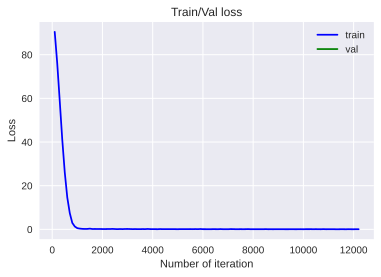

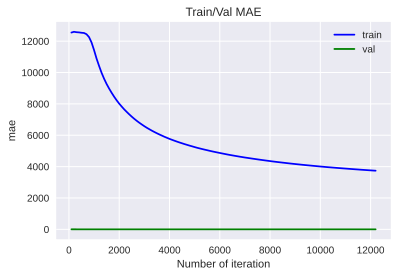

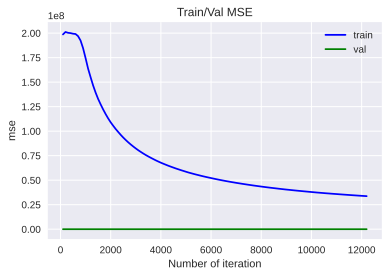

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_avp_best_checkpoint', model_avp, optimizer)

Loading checkpoint './cnn_avp_best_checkpoint'
Loaded checkpoint './cnn_avp_best_checkpoint' from iteration 11899


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_avp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.01682
MAE:  0.04831
LOSS:  0.06728


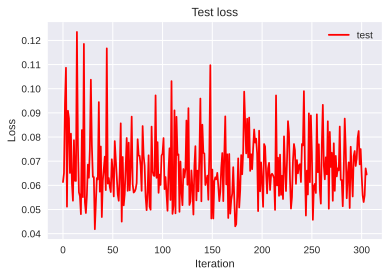

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Attentive pooling is an approach that enables the pooling layer to be aware of the current input pair, in a way that information from the question q can directly influence the computation of the answer representation ra, and vice versa.
* This model is better than the prev. one. Metrics decrease smoothly. The predictive ability of this model is very good.  Scores are great. 


* *** Average cross-validation scores ***: 

MSE:  0.01682  
MAE:  0.04831  
LOSS:  0.06728  


### **General conclusion №6**

Both pullings work perfectly and coped well with the task. Training of the model is fast due to the reduction of parameters. AttentivePooling worked best on our data, which can be seen by metrics and loss.